<a href="https://colab.research.google.com/github/pbrandao26/AnaliseDeDados_MVP_2023/blob/main/MVP_Analise_Dados_ContratosFuturosDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Introdução e objetivos

* **Introdução e Definição do Problema:**

Este trabalho explora dados históricos de contratos futuros de DI (Depósito Interfinanceiro) e sua relação com a taxa SELIC que, além de ser a taxa básica de juros da economia brasileira, serve como base para o cálculo do CDI, que por sua vez precifica diversos ativos de crédito de renda fixa no mercado primário e secundário. O objetivo é compreender como os dados de contratos do mercado futuro de DI podem influenciar ou refletir mudanças na taxa SELIC.

* **Descrição do Problema:**

O problema central deste estudo é investigar a dinâmica entre os contratos futuros de DI e a taxa SELIC, buscando padrões e correlações. O interesse nesta análise decorre da importância desses indicadores no mercado financeiro e na economia como um todo. O mercado futuro de DI é um dos principais instrumentos utilizados para a gestão de risco de taxa de juros no Brasil, enquanto a taxa SELIC é um indicador chave da política monetária do país.

* **Natureza do Problema:**

O projeto se insere no contexto do aprendizado supervisionado, com o objetivo final de desenvolver um modelo preditivo que utilize dados históricos de taxa de juros implícita dos contratos futuros de DI para prever a taxa SELIC. Embora a fase atual do projeto esteja focada na análise exploratória e no pré-processamento de dados, a definição do problema como aprendizado supervisionado é crucial, pois orienta as etapas subsequentes de modelagem e análise preditiva. Com essa abordagem, o projeto busca estabelecer relações quantitativas entre as variáveis e utilizar essas relações para fazer previsões informadas sobre a taxa SELIC.

* **Premissas e Hipóteses:**

 * Algumas premissas iniciais do estudo incluem:

    Os movimentos no mercado futuro de DI podem ser indicativos de expectativas de mercado sobre a taxa SELIC.
    A análise dos contratos futuros de DI pode fornecer insights sobre a percepção de risco e as tendências do mercado financeiro.
    Padrões históricos nos dados podem ser utilizados para inferir relações entre as variáveis.

* **Restrições e Condições dos Dados:**

Os dados foram selecionados com base em critérios de relevância para o mercado financeiro brasileiro e disponibilidade. O conjunto de dados inclui informações sobre negociações de contratos futuros de DI desde 2001, além de dados históricos da taxa SELIC no mesmo período. Uma restrição importante é que o estudo se limita a uma análise exploratória, sem a construção de modelos preditivos nesta fase.

* **Definição dos Atributos do Dataset:**

O dataset contém diversos atributos relacionados às negociações dos contratos futuros de DI, incluindo:

    - Dados de abertura e fechamento dos contratos.

    - Volume de negociações.

    - Preço médio e último preço de ajuste.

    - Data de vencimento dos contratos.

    - A taxa de juros implícita calculada a partir dos contratos.

    - Dados históricos da taxa SELIC correspondentes às datas dos contratos.

# 2 - Bloco dos "imports"

No bloco inicial do script, destinado à importação das funções, suprimimos avisos com `warnings.filterwarnings("ignore")` para manter a saída limpa. Importamos `datetime` para lidar com datas e horas, `pandas` para gerenciamento de dados, `matplotlib.pyplot` e `seaborn` para visualização de dados, e `numpy` para cálculos numéricos. Utilizamos `MinMaxScaler` e `StandardScaler` do `scikit-learn` para normalizar e padronizar os dados, respectivamente, e `PCA` para complementar a análise exploratória através da redução de dimensionalidade. A função `train_test_split` é usada para dividir os dados em conjuntos de treinamento e teste, e `statsmodels` é importada para modelagem estatística e análise de séries temporais, incluindo o cálculo de autocorrelação (**acf**) e autocorrelação parcial (**pacf**). Por último, `missingno` nos auxilia na visualização de dados faltantes no dataset. Este conjunto de importações e configurações prepara o ambiente para as análises e manipulações de dados que seguirão no trabalho.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import datetime
import missingno as ms
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import busday_count
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#3 - Bloco das funções

As funções definidas neste bloco são fundamentais para o pré-processamento e análise dos dados financeiros:

* **calcular_taxa_juros_implícita**: Calcula a taxa de juros implícita de um contrato futuro de DI. Utiliza o número de dias úteis entre datas de negociação e vencimento, considerando feriados, para ajustar o preço e calcular a taxa. Validações são feitas para evitar erros como divisão por zero.

* **converter_data_antiga**: Converte datas de vencimento de um formato antigo para um novo, baseado em um mapeamento de meses para letras. Essa função é particularmente útil para manter a consistência dos dados ao longo do tempo, especialmente pois o dataset contém informações históricas que usam diferentes formatos de data.

* **converter_vencimento**: Transforma o código de vencimento, que neste ponto já é uma combinação de uma letra e números, para um formato de data mais compreensível (Mês/Ano). Este formato padronizado é crucial para a comparação e análise de contratos com diferentes datas de vencimento.

* **calcular_meses_para_vencimento**: Calcula a diferença em meses entre a data de registro e a data de vencimento de um contrato. Esta função é usada para avaliar o prazo de um contrato, que é uma variável importante na análise financeira.

* **plotar_acf_pacf**: Gera gráficos de autocorrelação (ACF) e autocorrelação parcial (PACF) para séries temporais, o que é útil para identificar padrões e dependências temporais nos dados.

In [2]:
# Função para calcular a taxa de juros implícita
def calcular_taxa_juros_implicita(ajuste, data, data_vencimento, feriados):
    # Calculando N, o número de dias úteis entre as datas considerando feriados
    N = np.busday_count(data.date(), data_vencimento.date(), holidays=feriados)

    # Evitando divisão por zero e dias negativos
    if ajuste == 0 or N <= 0:
        return np.nan

    # Calculando a taxa de juros implícita
    P_DI = ajuste
    DI = ((100000 / P_DI ) ** (252 / N)) - 1
    return DI * 100  # Convertendo para porcentagem

# Função para converter formatos de datas antigas
def converter_data_antiga(data_antiga, data_negociacao):
    mes_para_letra = {
        'jan': 'F', 'fev': 'G', 'mar': 'H', 'abr': 'J',
        'mai': 'K', 'jun': 'M', 'jul': 'N', 'ago': 'Q',
        'set': 'U', 'out': 'V', 'nov': 'X', 'dez': 'Z'
    }

    if '/' in data_antiga:  # Verifica se está no formato antigo
        mes, ano = data_antiga.split('/')
        ano_corrigido = int(ano)
        data_negociacao_dt = datetime.datetime.strptime(data_negociacao, "%d/%m/%Y")
        ano_negociacao = data_negociacao_dt.year
        mes_negociacao = data_negociacao_dt.month

        # Convertendo o mês para formato numérico
        mes_numero = list(mes_para_letra.keys()).index(mes.lower()[:3]) + 1

        # Se a data de vencimento estiver no mesmo mês e ano da negociação, mantém como está
        if ano_corrigido == ano_negociacao % 100 and mes_numero == mes_negociacao:
            ano_corrigido = ano_negociacao
        # Se a data de vencimento for anterior à data de negociação, ajusta para 10 anos à frente
        elif ano_corrigido < ano_negociacao % 100 or (ano_corrigido == ano_negociacao % 100 and mes_numero < mes_negociacao):
            ano_corrigido += 10

        # Garantindo que o ano tenha sempre dois dígitos
        ano_formatado = str(ano_corrigido)[-2:].zfill(2)

        nova_data = mes_para_letra[mes.lower()[:3]] + ano_formatado
        return nova_data
    else:
        return data_antiga  # Retorna a data como está se já estiver no formato novo

# Função para converter o código de vencimento para o formato Mês/Ano
def converter_vencimento(codigo):

    # Dicionário para mapear as letras para os meses
    meses = {
        'F': 'Jan', 'G': 'Feb', 'H': 'Mar', 'J': 'Apr',
        'K': 'May', 'M': 'Jun', 'N': 'Jul', 'Q': 'Aug',
        'U': 'Sep', 'V': 'Oct', 'X': 'Nov', 'Z': 'Dec'
    }

    mes = meses.get(codigo[0])  # Obtém o mês correspondente à letra
    ano = "20" + codigo[1:]     # Prepara o ano (adiciona '20' ao início)
    return f"{mes}/{ano}"

# Função para calcular a diferença em meses
def calcular_meses_para_vencimento(data_registro, data_vencimento):
    if pd.isna(data_vencimento):
        return None
    return (data_vencimento.year - data_registro.year) * 12 + data_vencimento.month - data_registro.month

# Função para plotar ACF e PACF
def plotar_acf_pacf(serie, titulo, ax):
    sm.graphics.tsa.plot_acf(serie, ax=ax[0])
    sm.graphics.tsa.plot_pacf(serie, ax=ax[1])
    ax[0].set_title(f'ACF - {titulo}')
    ax[1].set_title(f'PACF - {titulo}')
    return

#4 - Carregando os datasets

* **Carregamento de dados**: Este bloco é dedicado ao carregamento de datasets essenciais para a análise financeira. Utilizando a função `pd.read_csv` do Pandas, são carregados três conjuntos de dados distintos: negociações de contratos futuros de DI a partir de 2001, dados históricos da taxa Selic anualizada desde 2001 e um calendário de feriados nacionais até 2099. Cada dataset é acessado através de um link específico referente ao arquivo raw no meu [GitHub](https://github.com/pbrandao26/AnaliseDeDados_MVP_2023/tree/main/DataSets) e carregado em um DataFrame separado.

* **Configurações de exibição**: Com `pd.set_option`, são ajustadas as configurações de exibição do Pandas para permitir a visualização completa das colunas e otimizar a largura de exibição no output. Isso garante que todas as informações relevantes sejam visíveis quando os DataFrames são impressos na tela, facilitando a análise e o debug dos dados carregados.


In [3]:
# Carregando os dados dos arquivos CSV
#Dados das negociações dos contratos futuros de DI desde 2001
file_path = 'https://raw.githubusercontent.com/pbrandao26/AnaliseDeDados_MVP_2023/main/DataSets/dados_bmf_contratos_futuros_di.csv'
df = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')

#Dados históricos da taxa selic anualizada desde 2001
file_path_selic = 'https://raw.githubusercontent.com/pbrandao26/AnaliseDeDados_MVP_2023/main/DataSets/STP-20231210134429041.csv'
df_selic = pd.read_csv(file_path_selic, sep=';')

#Calendário dos feriados nacionais até 2099
file_path_feriados = 'https://raw.githubusercontent.com/pbrandao26/AnaliseDeDados_MVP_2023/main/DataSets/feriados_nacionais.csv'
df_feriados = pd.read_csv(file_path_feriados, sep=';')

#Ajsutando exibição para os prints
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


## 4.1 - Fonte dos dados

Os três datasets carregados se complementam para viabilizar o estudo e cumprir com o objetivo proposto no trabalho. Cada fonte de dados foi obtida de maneira distinta:

* **Dados históriocos de contratos futuros de DI**: Para obter os dados dos contratos futuros de DI negociados diariamente desde 2001, foi necessário criar um script de raspagem (*webscraping*) para acessar os dados no [site da BM&F](https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data=&Mercadoria=DI1) (Bolsa de Mercados e Futuros). Embora o desenvolvimento de um script de raspagem não seja o foco principal deste trabalho, o script utilizado para acessar e consolidar os dados no site da BM&F está disponível no mesmo[ diretório do GitHub](https://github.com/pbrandao26/AnaliseDeDados_MVP_2023/blob/main/Webscraping_BMF/ScrapingMVP_Contratos_Futuros_DI.py) onde os demais datasets estão localizados. Caso tenha o interesse em análisa-lo, pode seguir clicando no texto sublinhado.

* **Calendário dos feriados nacionais**: O calendário com os feriados nacionais serve como parâmetro para ajustar o calculo de dias úteis. O dataset foi obtido diretamente no site da [ANBIMA](https://www.anbima.com.br/feriados/feriados.asp).

* **Série histórica da taxa selic**: A série histórica da taxa selic é a nossa variável de objetivo, a qual vamos tentar explicar o seu comportamente através das taxas implícitas calculadas com base nos contratos futuros de DI. Os dados foram obtidos diretamente no [repositório de séries históricas do Banco Central do Brasil](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries).


# 5 - Análise exploratória e pré-processamento

Nesta etapa vamos dar prosseguimento às etapas de análise exploratória e pré-processamento dos dados.

Este resumo abrange as principais operações e descobertas da etapa de análise exploratória e pré-processamento dos dados. As operações realizadas foram fundamentais para a preparação dos dados para análises futura.

É importante frisar que o processo de análise e pré-processamento foram iterativos, ou seja, não há uma separação clara no trabalho que o divida em análise exploratória e pré-processamento, mas sim foi traçado um caminho para que a leitura faça sentido.

## 5.1 - Resumo da Análise de Dados

- **Apresentação de Estatísticas Descritivas:**

 - Identificação da quantidade de atributos e instâncias no conjunto de dados principal;

 - Os tipos de dados variam entre numéricos e categóricos, incluindo datas e valores monetários;

 - A análise das primeiras linhas revelou a necessidade de transformações, como a conversão de datas e a padronização de formatos;

 - Foram identificados valores faltantes e discrepâncias, principalmente em colunas como volume de negociações e taxas de juros;

 - Um resumo estatístico dos atributos numéricos foi realizado, destacando características chave, como a variação do volume de negociações e os valores de ajuste dos contratos.

- **Visualizações de Dados:**

  - Análise de *missings* e variáveis zeradas;

 - Distribuições do atributo de volume foram examinadas, revelando insights sobre a necessidade de normalização e tratamento de outliers;

 - A análise gráfica incluiu a distribuição de volumes, histogramas de meses para vencimento e a correlação entre taxa SELIC e taxa de juros implícita;

 - A matriz de correlação buscou avaliar influências lineares entre atributos;

  - Gráficos box-plots foram plotados para analisar a variação histórica da taxa SELIC e das taxas de juros implícitas, bem como seus outliers e intervalos interquartílicos;

  - Implementação da Análise de Componentes Principais (PCA) como medida exploratória para identificar padrões;

  - Análise dos pesos dos componentes principais revelou a importância de características como preços e volumes de negociações na variação dos dados;

  - Análise de séries temporais utilizando Autocorrelação (ACF) e Autocorrelação Parcial (PACF) para a taxa SELIC e para a mediana das taxas de juros implícitas, visando identificar padrões e dependências temporais.


## 5.2 - Resumo do Pré-processamento de Dados

O pré-processamento dos dados foi uma etapa crucial para garantir a qualidade e a relevância das informações analisadas. As operações realizadas abrangeram diversos aspectos essenciais:

- **Limpeza e Tratamento de Dados**: Eliminação de inconsistências, valores ausentes (identificados como 0 na coluna de volume) e erros nos dados para assegurar a precisão das análises subsequentes. A limpeza de dados foi cuidadosamente realizada para manter a integridade e representatividade dos dados, evitando distorções nas análises.

- **Normalização**: Em particular, a coluna de volume de negociações passou por um processo de normalização usando `MinMaxScaler` a fim de facilitar a identificação dos ranges de volume e criar uma nova coluna discretizada classificando os volumes.

- **Feature Engineering**: Desenvolvimento de novos atributos a partir dos dados existentes, como a criação de indicadores de liquidez e a aplicação de funções customizadas para calcular a taxa de juros implícita.

- **Conversão de Datas**: Ajuste e padronização dos formatos de data, um passo vital para análises temporais e comparações de tendências ao longo do tempo.

- **Discretização e Categorização**: Classificação de dados contínuos em categorias discretas para facilitar análises específicas.

- **Enriquecimento**: Agregação de novas informações, vindas de diferentes, fontes consolidadas em um único dataset.

Após cada etapa de pré-processamento, novas rodadas de análises exploratórias foram conduzidas, revelando insights valiosos. A influência do tempo para o vencimento nos contratos e a sua relação com a taxa SELIC foram mais claramente compreendidas.

## 5.3 - Avaliações e tratamentos

A seguir, vamos dar continuidade às análises e aos processos de pré-processamento de maneira aprofundada em Python.

### 5.3.1 - Quantidade de atributos e instâncias




In [4]:
# 1. Quantos atributos e instâncias existem
num_atributos = df.shape[1]
num_instancias = df.shape[0]
print("Número de Atributos:", num_atributos)
print("Número de Instâncias:", num_instancias)

Número de Atributos: 18
Número de Instâncias: 187587


* **Exploração inicial dos dados**: Este trecho de código realiza uma inspeção inicial da estrutura dos DataFrames carregados, determinando a quantidade de atributos (colunas) e instâncias (linhas) presentes no dataset dos contratos futuros de DI. Utilizando `df.shape`, obtém-se as dimensões do DataFrame, que são impressas para fornecer uma visão geral rápida do tamanho do dataset.

* **Resultados da inspeção**: A saída indica que o DataFrame possui 18 atributos e 187587 instâncias.

### 5.3.2 - Avaliação dos tipos de dados e remoção de colunas



In [5]:
# 2. Quais são os tipos de dados dos atributos
tipos_dados = df.dtypes
print("\nTipos de Dados dos Atributos:\n", tipos_dados)


Tipos de Dados dos Atributos:
 VENCTO                 object
CONTR. ABERT.(1)       object
CONTR. FECH.(2)        object
NÚM. NEGOC.           float64
CONTR. NEGOC.          object
VOL.                   object
AJUSTE ANTER. (3)      object
AJUSTE CORRIG. (4)     object
PREÇO ABERT.           object
PREÇO MÍN.             object
PREÇO MÁX.             object
PREÇO MÉD.             object
ÚLT. PREÇO             object
AJUSTE                 object
VAR. PTOS.             object
ÚLT. OF. COMPRA        object
ÚLT. OF. VENDA         object
Data                   object
dtype: object


No dataset, uma variedade de tipos de dados pode ser observada, conforme indicado pela saída do código. Muitos dos atributos são do tipo `object`, o que, no contexto de pandas, geralmente indica dados textuais ou mistos (textos e números). A presença predominante de tipos `object` sugere a necessidade de conversões e limpezas adicionais, já que muitos desses atributos podem representar, na verdade, valores numéricos, datas ou categorias.

In [6]:
#Removendo colunas que não serão usadas
# Lista de colunas a serem removidas
colunas_para_remover = ['VAR. PTOS.', 'NÚM. NEGOC.', 'CONTR. NEGOC.', 'AJUSTE ANTER. (3)',
                        'AJUSTE CORRIG. (4)', 'PREÇO ABERT.', 'PREÇO MÍN.', 'PREÇO MÁX.',
                        'ÚLT. OF. COMPRA', 'ÚLT. OF. VENDA',]

# Removendo as colunas
df = df.drop(columns=colunas_para_remover)

# 3. Verifique as primeiras linhas do dataset
primeiras_linhas = df.head(15)
ultimas_linhas = df.tail(15)
print("\nPrimeiras Linhas do Dataset:\n", primeiras_linhas)
print("\nÚltimas Linhas do Dataset:\n", ultimas_linhas)


Primeiras Linhas do Dataset:
     VENCTO CONTR. ABERT.(1) CONTR. FECH.(2)           VOL. PREÇO MÉD. ÚLT. PREÇO      AJUSTE        Data
0   jan/01          186.177               0              0          0          0  100.000,00  02/01/2001
1   fev/01          135.828         138.253    674.755.900  98.735,13  98.736,00   98.735,00  02/01/2001
2   mar/01           34.238          34.803    217.592.465  97.706,54  97.701,00   97.701,00  02/01/2001
3   abr/01          228.916         230.739  1.303.147.560  96.458,00  96.445,00   96.446,54  02/01/2001
4   mai/01                0             100      9.532.000  95.320,00  95.320,00   95.299,00  02/01/2001
5   jul/01          171.225         168.894  4.234.309.450  92.898,41  92.875,00   92.878,16  02/01/2001
6   out/01           15.845          17.195    174.080.750  89.272,18  89.215,00   89.215,00  02/01/2001
7   nov/01              604             604              0          0          0   87.985,00  02/01/2001
8   jan/02            9.

Neste segmento do código, iniciamos o processo de limpeza e entendimento do dataset:

- **Remoção de Colunas Irrelevantes:**

O código começa com a remoção de colunas consideradas irrelevantes para a análise. Essas colunas incluem variáveis que foram excluídas para simplificar o dataset e focar nas informações mais pertinentes.

- **Visualização das Primeiras e Últimas Linhas:**

Em seguida, são exibidas as primeiras e últimas 15 linhas do dataset para uma inspeção inicial dos dados.

Ao observar as primeiras e últimas linhas do dataset, podemos extrair algumas informações e percepções importantes:

 - Diversidade nos Formatos de Dados: Há uma variedade nos formatos dos dados, especialmente em colunas de valores numéricos como **PREÇO MÉD.**, e **ÚLT. PREÇO**, onde nos dados mais recentes estes já se encontram refletindo a taxa de juros implícita calculada e nos dados mais antigos eles se apresentam da mesma forma que o ajuste.

 - Datas de Vencimento e Negociação: As colunas **VENCTO** e **Data** contêm informações temporais, mas estão em formato de texto (object). A conversão para o formato datetime é essencial para facilitar operações temporais e comparações. Além disso, é possível perceber que a coluna **VENCTO** está adotando padrões distintos para representar o vencimento do contrato, onde dados mais antigos estão na forma de mês/ano e os dados mais recentes adotam a forma padrão já conhecida pelo contratos futuros negociados na BM&F, com letras que simbolizam o mês de vencimento e o sufixo do ano de vencimento.

 - Variação no Volume de Negociações: A coluna **VOL.** mostra uma ampla variação nos volumes de negociação, incluindo muitos zeros, o que pode indicar dias sem negociações ou a presença de dados incompletos.

### 5.3.3 - Tratamento de datas e tipos

In [7]:
# Convertendo colunas de vencimento e data

# Aplicando a conversão na coluna "VENCTO"
df['VENCTO'] = df.apply(lambda x: converter_data_antiga(x['VENCTO'], x['Data']), axis=1)

df['VENCTO_EXPLICADO'] = pd.to_datetime(df['VENCTO'].apply(converter_vencimento), format='%b/%Y', errors='coerce')
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

# Convertendo campos numéricos que estão como strings
# Substituir vírgulas por nada e pontos por vírgulas, em seguida converter para float
# Adaptando as colunas conforme necessário
colunas_para_converter = ['CONTR. ABERT.(1)', 'CONTR. FECH.(2)', 'VOL.', 'ÚLT. PREÇO', 'AJUSTE', 'PREÇO MÉD.']

for coluna in colunas_para_converter:
    df[coluna] = pd.to_numeric(df[coluna].str.replace('.', '').str.replace(',', '.'), errors='coerce')


# 4. Verificando novamente os tipos de dados
tipos_dados_corrigidos = df.dtypes
print("\nTipos de Dados Corrigidos dos Atributos:\n", tipos_dados_corrigidos)


Tipos de Dados Corrigidos dos Atributos:
 VENCTO                      object
CONTR. ABERT.(1)             int64
CONTR. FECH.(2)              int64
VOL.                         int64
PREÇO MÉD.                 float64
ÚLT. PREÇO                 float64
AJUSTE                     float64
Data                datetime64[ns]
VENCTO_EXPLICADO    datetime64[ns]
dtype: object


Neste segmento do código, o foco está em converter e ajustar os formatos de dados para tipos mais apropriados para análise:

- Conversão de Datas:

A coluna **VENCTO** é convertida usando a função **converter_data_antiga**, que adapta as datas de vencimento para o formato atual padronizado.

A coluna **VENCTO_EXPLICADO** criada com base na função **converter_vencimento** que traduz a sigla do vencimento padrão de contratos futuros para o seu formato de `datetime64` correspondente.

A coluna **data**, que é a data em que o contrato foi negociado, também é convertida para formato `datetime64`.

- Ajuste de Campos Numéricos:

As colunas **'CONTR. ABERT.(1)'**, **'CONTR. FECH.(2)'**, **'VOL.'**, **'ÚLT. PREÇO'**, **'AJUSTE'** e **'PREÇO MÉD.'** são convertidas para formatos numéricos. Isso envolve a substituição de vírgulas e pontos para corrigir o formato decimal, transformando-as de strings para números.

- Verificação dos Tipos de Dados:

Após as conversões, os tipos de dados são verificados novamente para confirmar as mudanças. Como resultado, as colunas agora apresentam tipos de dados mais adequados para análise, como `int64` para valores inteiros, `float64` para decimais e `datetime64[ns]` para datas.

In [8]:
primeiras_linhas = df.head(15)
ultimas_linhas = df.tail(15)
print("\nPrimeiras Linhas do Dataset:\n", primeiras_linhas)
print("\nÚltimas Linhas do Dataset:\n", ultimas_linhas)


Primeiras Linhas do Dataset:
    VENCTO  CONTR. ABERT.(1)  CONTR. FECH.(2)        VOL.  PREÇO MÉD.  ÚLT. PREÇO     AJUSTE       Data VENCTO_EXPLICADO
0     F01            186177                0           0        0.00         0.0  100000.00 2001-01-02       2001-01-01
1     G01            135828           138253   674755900    98735.13     98736.0   98735.00 2001-01-02       2001-02-01
2     H01             34238            34803   217592465    97706.54     97701.0   97701.00 2001-01-02       2001-03-01
3     J01            228916           230739  1303147560    96458.00     96445.0   96446.54 2001-01-02       2001-04-01
4     K01                 0              100     9532000    95320.00     95320.0   95299.00 2001-01-02       2001-05-01
5     N01            171225           168894  4234309450    92898.41     92875.0   92878.16 2001-01-02       2001-07-01
6     V01             15845            17195   174080750    89272.18     89215.0   89215.00 2001-01-02       2001-10-01
7     X01

Após as transformações de dados e ajustes de formatos, revisamos novamente as primeiras e últimas linhas do dataset para verificar as mudanças.

### 5.3.4 - Resumo estatístico do dataset

In [9]:
# 5. Resumo estatístico dos dados
print(df.describe())

       CONTR. ABERT.(1)  CONTR. FECH.(2)          VOL.     PREÇO MÉD.     ÚLT. PREÇO         AJUSTE
count      1.875870e+05     1.875870e+05  1.875870e+05  187587.000000  187587.000000  187587.000000
mean       3.852595e+05     3.849565e+05  3.337424e+09    1130.111755    1130.177350   70029.570183
std        8.168559e+05     8.178453e+05  9.961376e+09    9906.043019    9906.566703   22686.585326
min        0.000000e+00     0.000000e+00  0.000000e+00       0.000000       0.000000       0.000000
25%        8.396000e+03     8.261000e+03  4.814455e+05       3.882000       3.875000   53873.680000
50%        5.167000e+04     5.131700e+04  8.631148e+07      10.520000      10.520000   72453.980000
75%        3.847235e+05     3.834595e+05  1.809621e+09      12.724000      12.720000   90942.510000
max        1.514889e+07     1.514889e+07  6.353804e+11   99944.030000   99944.000000  100000.000000


O resumo estatístico dos dados fornece algumas informações sobre as características numéricas do dataset:

- Contagem (Count): A coluna 'count' mostra o número de observações não-NaN em cada coluna numérica, indicando que temos 187.587 observações para todas as colunas numéricas.

- Média (Mean): As médias das colunas variam significativamente. Enquanto '**CONTR. ABERT.(1)**', '**CONTR. FECH.(2)**' e '**VOL.**' têm médias na casa dos milhares e bilhões, as médias de '**PREÇO MÉD.**', '**ÚLT. PREÇO**' e '**AJUSTE**' estão mais próximas de 1000 a 70000, refletindo diferentes escalas e tipos de dados (contratos, volumes e valores financeiros).

- Desvio Padrão (Std): O desvio padrão alto em colunas como '**VOL.**' e valores financeiros indica uma grande variação nos dados, o que pode ser um indicador de volatilidade do mercado e comportamento dos preços.

- Mínimo (Min): Os valores mínimos de zero em várias colunas podem indicar dias sem negociações, contratos não abertos ou fechados e possíveis outliers ou dados incompletos.

- Quartis (25%, 50%, 75%): Os quartis mostram a distribuição dos dados, com 25% dos valores abaixo do primeiro quartil, 50% (mediana) abaixo do segundo quartil e 75% abaixo do terceiro quartil.

- Máximo (Max): Os valores máximos especialmente altos em algumas colunas sugerem a presença de valores extremos, que podem ser outliers ou representar eventos de mercado únicos.

### 5.3.5 - Análise de valores faltantes

In [10]:
# 6. Há valores faltantes, discrepantes ou inconsistentes
valores_faltantes = df.isnull().sum()
print("\nValores Faltantes por Atributo:\n", valores_faltantes)


Valores Faltantes por Atributo:
 VENCTO              0
CONTR. ABERT.(1)    0
CONTR. FECH.(2)     0
VOL.                0
PREÇO MÉD.          0
ÚLT. PREÇO          0
AJUSTE              0
Data                0
VENCTO_EXPLICADO    0
dtype: int64


A análise dos valores faltantes no dataset indica que todas as colunas estão completas, sem valores nulos. No entanto, como visto anteriormente, é importante destacar a presença de valores zero, especialmente na coluna de volume de negociações. Estes valores zero, embora tecnicamente não sejam nulos, podem representar dias em que não ocorreram atividades de mercado para determinados contratos. Essa característica merece atenção especial, pois reflete uma dimensão importante do comportamento do mercado, indicando possíveis períodos de inatividade ou um tempo muito longo para o vencimento em certos contratos futuros.

<Axes: >

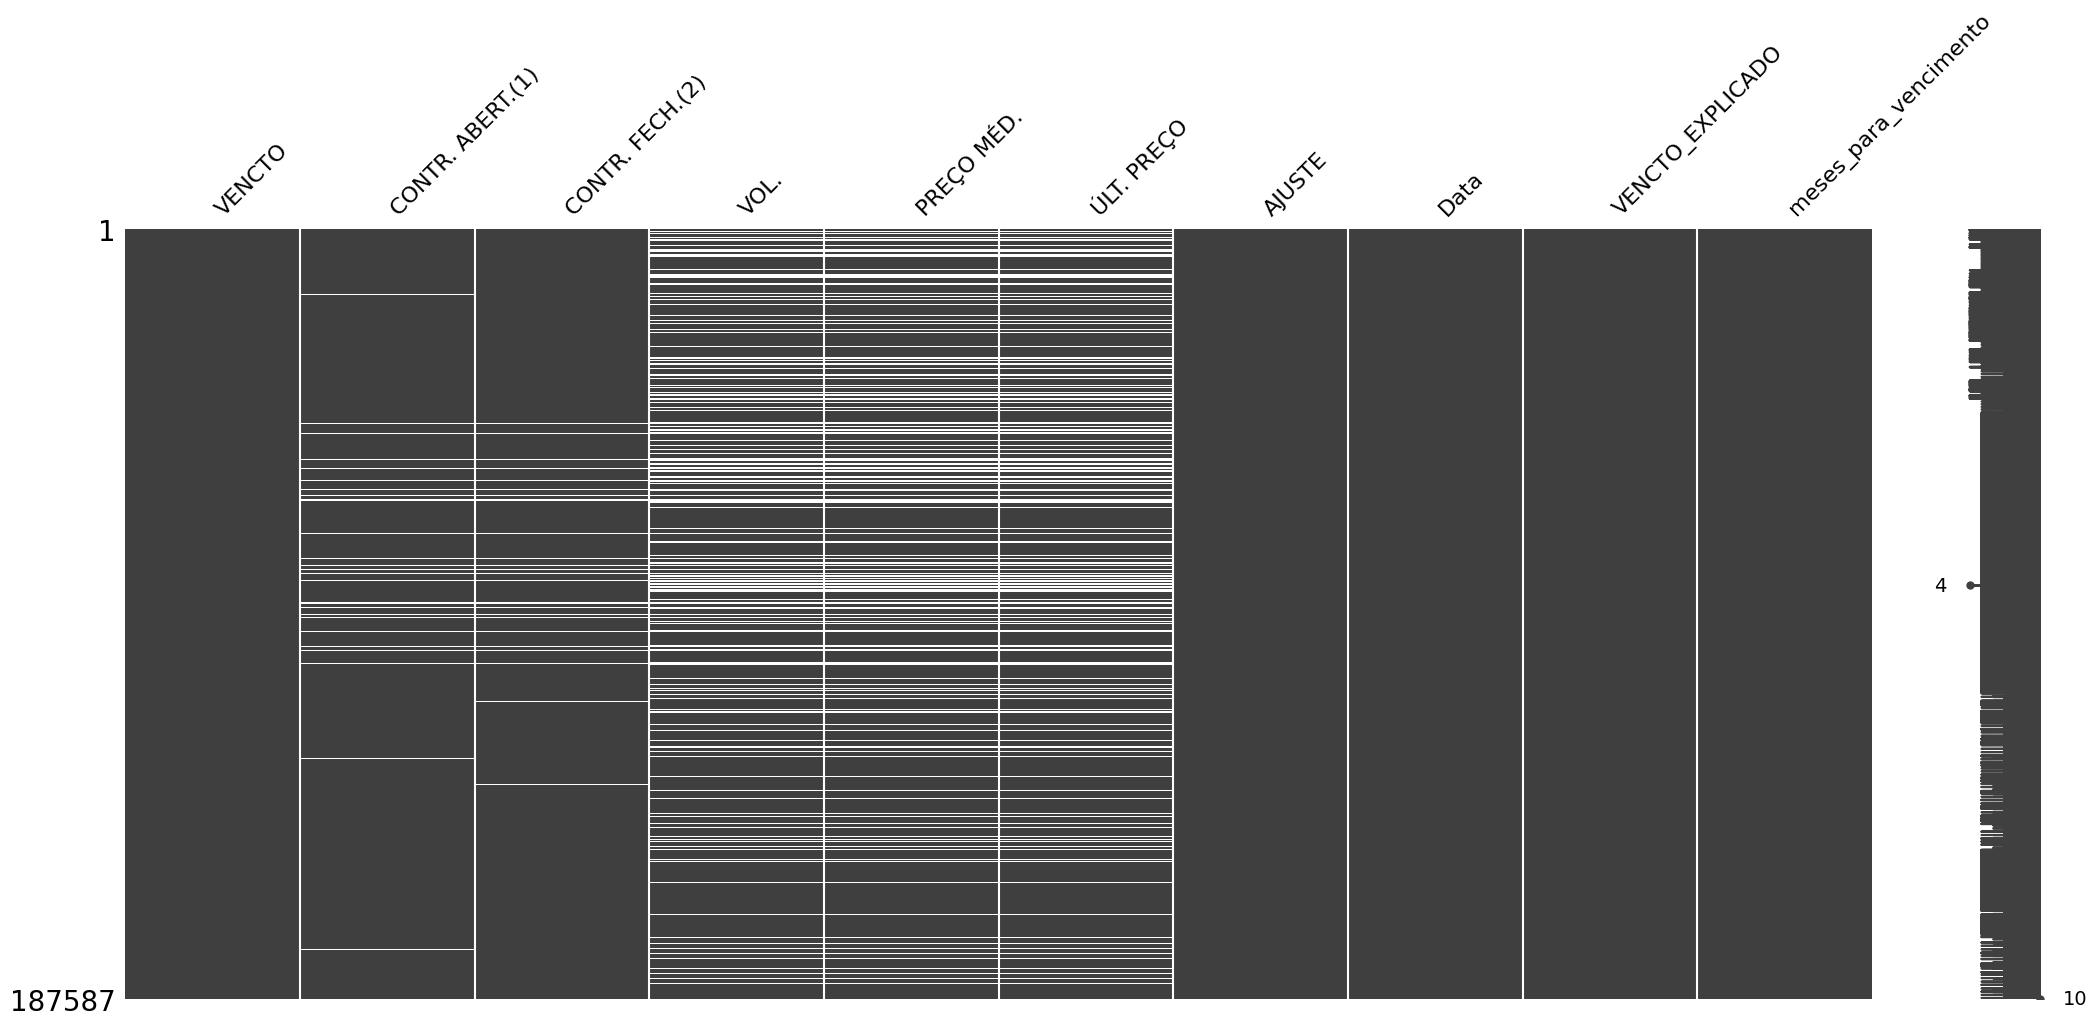

In [11]:
# Aplicando a função para criar a nova coluna
df['meses_para_vencimento'] = df.apply(lambda row: calcular_meses_para_vencimento(row['Data'], row['VENCTO_EXPLICADO']), axis=1)

# Criando uma cópia do DataFrame original para manter os dados completos
df_completo = df.copy()

# 7. Análisando possíveis missings
col = list(df.columns)
df_sem_missings = df[col[:]]
df_sem_missings.replace(0, np.nan, inplace = True)
ms.matrix(df_sem_missings)


Nesta etapa do código, focamos em aprofundar a análise baseada no tempo para o vencimento dos contratos futuros e explorar a questão dos volumes zerados:

* Criação da Coluna 'meses_para_vencimento':

Utilizamos a função **calcular_meses_para_vencimento** para criar uma nova coluna no DataFrame. Esta coluna calcula a diferença em meses entre a data de negociação (**Data**) e a data de vencimento do contrato (**VENCTO_EXPLICADO**).

* Cópia do DataFrame:

Criamos uma cópia do DataFrame original (**df_completo**). Esta prática é importante para preservar a integridade dos dados originais, permitindo manipulações e análises sem alterar o conjunto de dados principal.

* Análise de Valores Zero como Potenciais Missings:

Para investigar a presença e o impacto dos valores zero (especialmente na coluna de volume), substituímos esses valores por NaN em uma nova visão do DataFrame (**df_sem_missings**).

A visualização gerada pelo `missingno` oferece um gráfico de matriz que ilustra a completude dos dados em nosso DataFrame após substituir os valores zero por `NaN`. As linhas representam as entradas (ou registros) no dataset e as colunas representam as variáveis.

Colunas Preenchidas: As colunas **VENCTO**, **Data**, **VENCTO_EXPLICADO** e **AJUSTE** estão completamente preenchidas, o que é indicado pelas barras sólidas pretas, significando que não há valores zero ou `NaN` nestas colunas após a nossa transformação.

Colunas com Valores Ausentes (`NaN`): As colunas **CONTR. ABERT.(1)**, **CONTR. FECH.(2)**, **VOL.**, **PREÇO MÉD.**, **ÚLT. PREÇO** mostram faixas brancas horizontais que indicam a presença de valores ausentes (valores zero que foram convertidos em `NaN`).



In [12]:
# Vamos entender os zeros da coluna de volume
# Normalizando a coluna 'VOL.' para classificar os dados em grupos - Discretizando
# Usando MinMaxScaler para normalizar a coluna 'VOL.'
scaler = MinMaxScaler()

# O MinMaxScaler espera uma matriz 2D, então usamos .reshape(-1, 1) para transformar a série em uma matriz 2D
df['VOL_normalizado'] = scaler.fit_transform(df[['VOL.']].values.reshape(-1, 1))

# 8. Exibindo os dados normalizados e originais
print (df[['VOL.','VOL_normalizado']])

              VOL.  VOL_normalizado
0                0         0.000000
1        674755900         0.001062
2        217592465         0.000342
3       1303147560         0.002051
4          9532000         0.000015
...            ...              ...
187582     9262007         0.000015
187583           0         0.000000
187584           0         0.000000
187585           0         0.000000
187586           0         0.000000

[187587 rows x 2 columns]



Foi realizada uma normalização da coluna **VOL.** através do uso do `MinMaxScaler`, que transformou os valores de volume de negociações em uma escala de 0 a 1. Isso permite uma comparação equilibrada dos volumes de negociação entre diferentes dias, independentemente da variação extrema nos valores originais. Com a nova coluna **VOL_normalizado**, temos agora um panorama claro da atividade do mercado que é mais fácil de interpretar e que nos auxiliará na classificação dos dados em grupos discretos de volume.

In [13]:
# Definindo os intervalos e rótulos para os grupos - Discretizando
bins = [-np.inf, 0, 0.333, 0.666, 1]
labels = ['Volume Zero', 'Baixo Volume', 'Médio Volume', 'Alto Volume']

# Criando uma nova coluna para os grupos de volume
df['Grupo_Volume'] = pd.cut(df['VOL_normalizado'], bins=bins, labels=labels, include_lowest=True)

# 9. Verificando como os dados estão distribuídos entre os grupos
print(df['Grupo_Volume'].value_counts())

Baixo Volume    144531
Volume Zero      43039
Médio Volume        16
Alto Volume          1
Name: Grupo_Volume, dtype: int64


A aplicação da discretização na coluna de volume normalizado permitiu a categorização dos dados em quatro grupos distintos. O grupo '**Baixo Volume**' engloba a maioria dos dados, indicando uma frequência elevada de negociações com volumes relativamente mais baixos quando comparados ao espectro total de negociações. Por outro lado, o grupo '**Volume Zero**' representa uma parcela significativa do dataset, o que sugere muitos dias sem atividade de negociação no mercado. Por fim, há apenas 16 ocorrências no grupo '**Médio Volume**' e uma única ocorrência no grupo '**Alto Volume**', o que pode denotar eventos de negociação extremamente raros ou atípicos, possivelmente dias de alta volatilidade no mercado ou eventos específicos que influenciaram o volume de negociações.

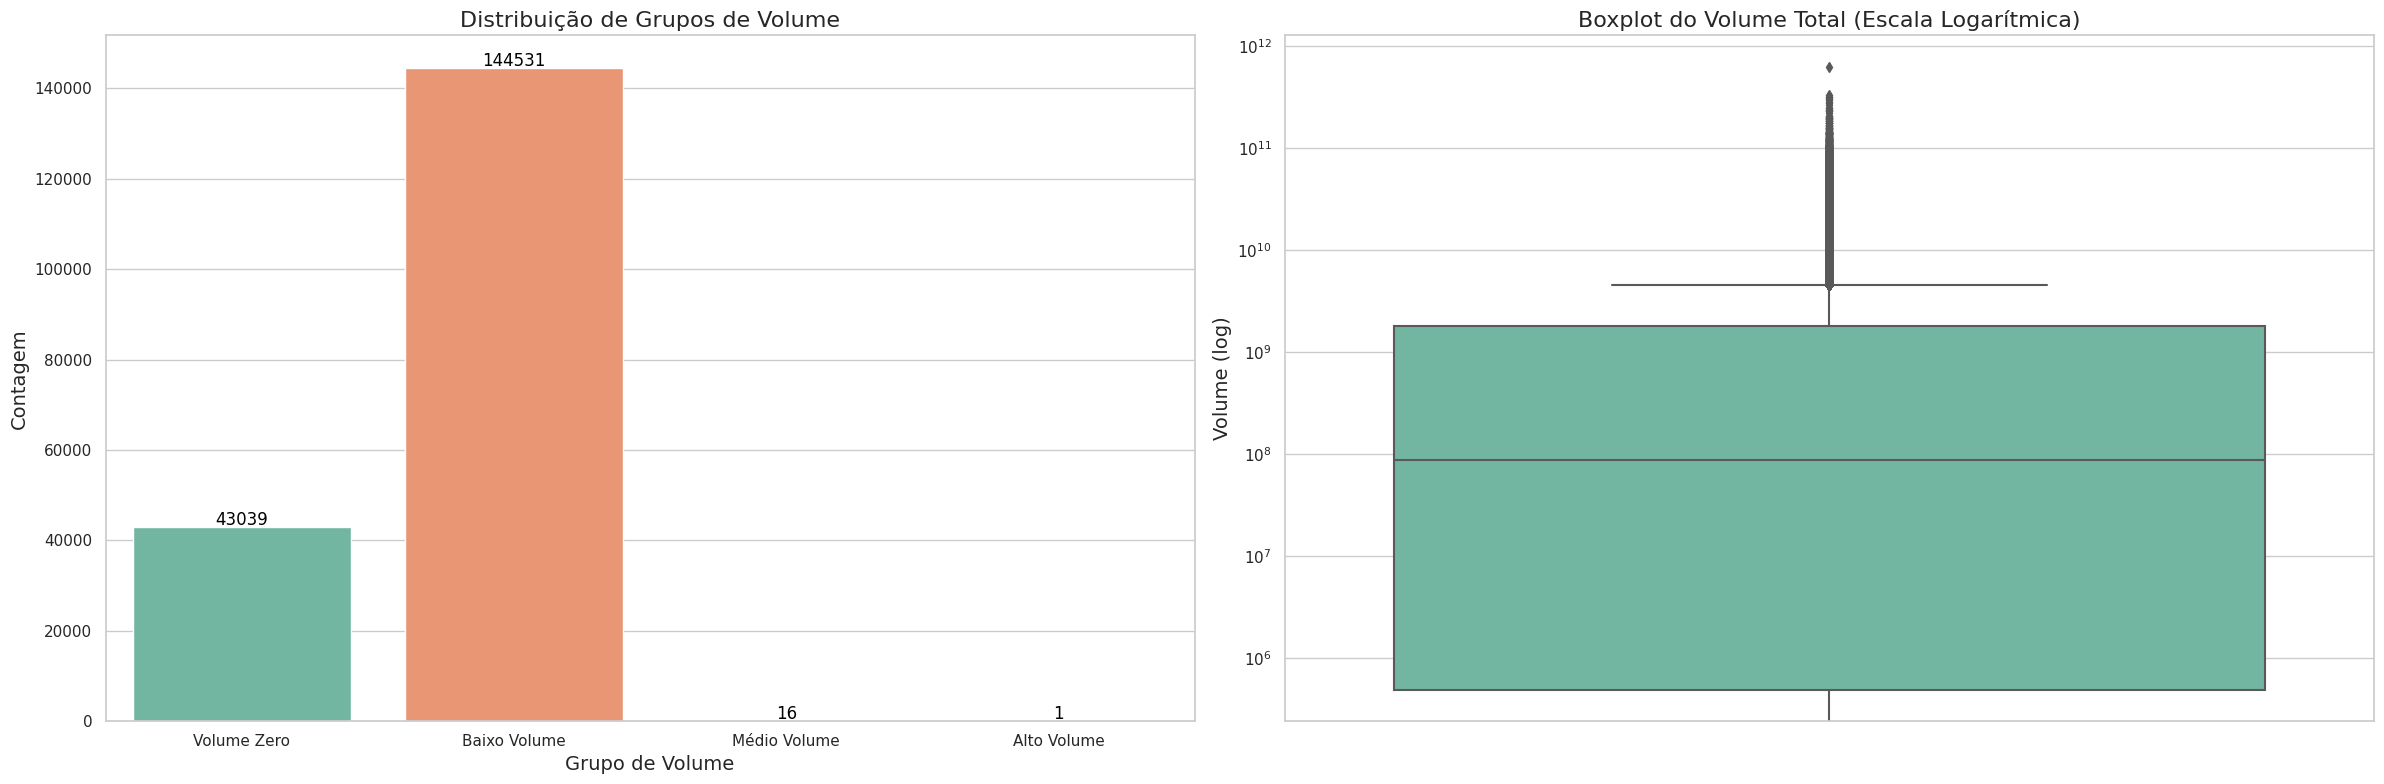

In [14]:
# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

# Criando uma figura com dois subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

# Gráfico de barras no primeiro subplot
ax1 = sns.countplot(x='Grupo_Volume', data=df, palette='Set2', ax=axes[0])
ax1.set_title('Distribuição de Grupos de Volume', fontsize=16)
ax1.set_xlabel('Grupo de Volume', fontsize=14)
ax1.set_ylabel('Contagem', fontsize=14)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

# Boxplot da variável 'VOL.' no segundo subplot com escala logarítmica
ax2 = sns.boxplot(y='VOL.', data=df, palette='Set2', ax=axes[1])
ax2.set_yscale('log')  # Aplicando escala logarítmica
ax2.set_title('Boxplot do Volume Total (Escala Logarítmica)', fontsize=16)
ax2.set_ylabel('Volume (log)', fontsize=14)

# Ajustando o layout
plt.tight_layout()

# 10. Exibindo a figura com ambos os gráficos
plt.show()


O código configura o estilo dos gráficos para um fundo de grade branca, cria uma figura com dois subplots lado a lado e utiliza a biblioteca `Seaborn` para gerar um gráfico de barras e um boxplot. O gráfico de barras exibe a distribuição de dados discretizados em grupos de volume, com a altura das barras representando a contagem de registros em cada grupo. As anotações nas barras facilitam a visualização do número exato de registros.

O boxplot apresenta a distribuição do volume de negociações ('**VOL.**') em escala logarítmica, o que é útil para visualizar dados com uma grande amplitude de escala, como é o caso do volume de negociações. A escala logarítmica permite que valores extremamente altos e baixos sejam representados de forma que os detalhes em ambas as extremidades da escala possam ser visualizados. No boxplot, podemos observar a mediana (linha dentro da caixa), os quartis (bordas da caixa), e os outliers (pontos distantes da caixa), fornecendo uma visão da dispersão dos dados de volume e destacando valores que se desviam significativamente da média.

Analisando o boxplot, notamos:

-  A presença de outliers acima da média, indicando dias com volumes de negociação excepcionalmente altos;

- A linha central da caixa (mediana) está mais próxima do quartil superior, sugerindo que a maioria dos dias tem volumes de negociação mais altos, enquanto os outliers refletem os picos de atividade no mercado.

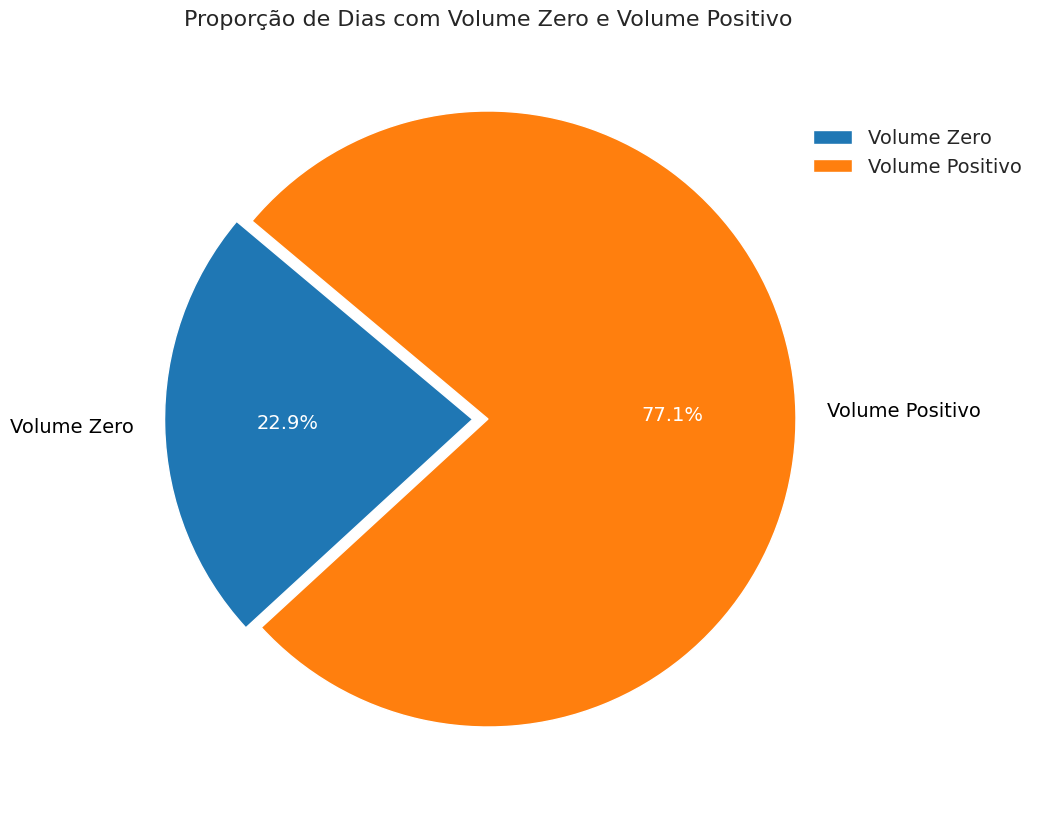

In [15]:
# Gráfico de pizza para proporção de dias com volume zero
volume_zero_count = (df['VOL.'] == 0).sum()
volume_positivo_count = (df['VOL.'] > 0).sum()

categorias = ['Volume Zero', 'Volume Positivo']
contagens = [volume_zero_count, volume_positivo_count]
# Configurando o tamanho do gráfico
plt.figure(figsize=(10, 10))

# Definindo cores
cores = ['#1f77b4', '#ff7f0e']
# Criando o gráfico de pizza
patches, texts, autotexts = plt.pie(contagens, labels=categorias, autopct='%1.1f%%', startangle=140, colors=cores, explode=(0.05, 0))
# Destacando o segmento de 'Volume Zero'
patches[0].set_edgecolor('white')
patches[1].set_edgecolor('white')

# Ajustando as fontes
for text in texts:
    text.set_color('black')
    text.set_fontsize(14)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)

# Adicionando título
plt.title('Proporção de Dias com Volume Zero e Volume Positivo', fontsize=16)
# Ajustando a legenda
plt.legend(frameon=False, bbox_to_anchor=(0.9, 0.9), loc="upper left", fontsize=14)
# 11. Exibindo o gráfico
plt.show()

No código apresentado, um gráfico de pizza é utilizado para mostrar a proporção de dias com volume de negociação igual a zero em comparação com os dias que tiveram volume positivo. O código calcula a contagem de dias por contrato para cada categoria e utiliza estas contagens para desenhar o gráfico de pizza. As cores são definidas para distinguir visualmente as duas categorias, e uma pequena explosão é aplicada ao segmento de 'Volume Zero' para destacá-lo. A posição da legenda é ajustada para não sobrepor o gráfico, e são feitas personalizações no estilo do título e das anotações percentuais para melhor legibilidade.

Analisando o gráfico gerado, é evidente que a grande maioria dos dias por contrato teve algum volume de negociação (Volume Positivo), enquanto uma porção menor de dias não teve negociações (Volume Zero). Isso pode ser interpretado como uma indicação da atividade do mercado, onde em cerca de 77.1% dos dias houve negociações ativas, e em aproximadamente 22.9% dos dias, não houve negociação. Uma possível justificativa para esse fato é o tempo para o vencimento dos contratos. Vamos análisar isso mais a fundo posteriormente

Como a quantidade de dias sem negociação por contrato reflete uma parcela relevante do nosso dataset e, esses dias são momentos onde não houve atividade de negociação nos determinados contratos, vamos remover essas linhas.

<Axes: >

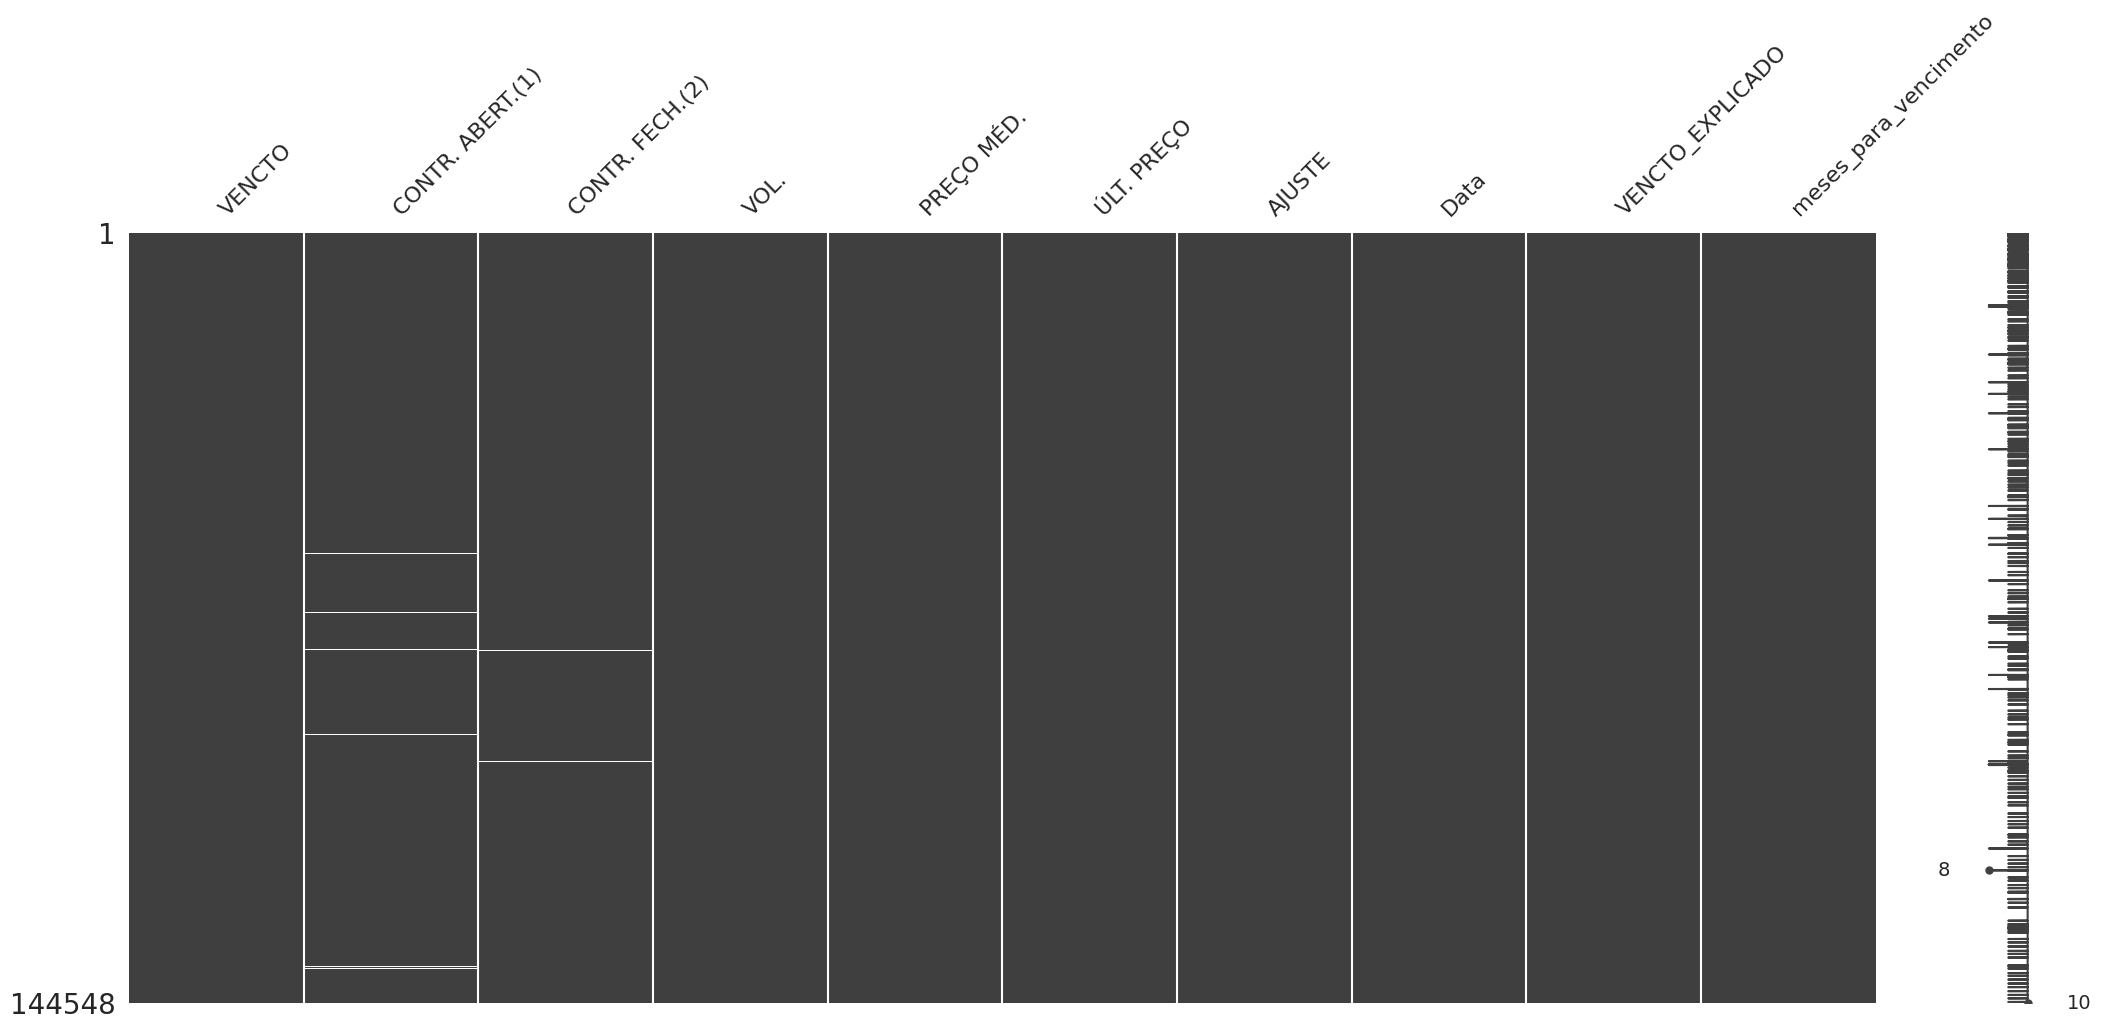

In [16]:
# Filtrando para volumes iguais a zero e maiores que zero
df_vol_zero = df[df['VOL.'] == 0]
df = df[df['VOL.'] > 0]

# 12. Verificando novamente os missings
df_sem_missings = df[col[:]]
df_sem_missings.replace(0, np.nan, inplace = True)
ms.matrix(df_sem_missings)

Neste segmento do código, realizou-se uma filtragem para separar e analisar os conjuntos de dados baseados no volume de negociações. A separação foi entre os registros com volume de negociação igual a zero e aqueles com volume positivo. Isso resultou na remoção de uma parte significativa dos dados (22,9%), reduzindo o número de linhas de 187.587 para 144.548.

O gráfico resultante do `ms.matrix` mostra que, após a remoção dos registros com volume zero, o dataset agora apresenta uma consistência maior, indicada pela predominância das barras pretas, o que significa uma menor quantidade de valores considerados nulos (ou zeros neste caso). Isso sugere que a qualidade dos dados para análise subsequente melhorou, pois, como abordamos, os dados sem atividade de mercado (volume zero) podem distorcer a análise de tendências e padrões. A matriz de ausência de dados agora indica que os atributos relevantes para a análise possuem informações mais completas e confiáveis.

Os poucos valores zerados para as colunas de Contratos Abertos e Fechados não precisam ser tratados, uma vez que estes atributos podem perfeitamente adquirir valorez iguais a zero.

In [17]:
primeiras_linhas = df.head(15)
ultimas_linhas = df.tail(15)
print("\nPrimeiras Linhas do Dataset:\n", primeiras_linhas)
print("\nÚltimas Linhas do Dataset:\n", ultimas_linhas)


Primeiras Linhas do Dataset:
    VENCTO  CONTR. ABERT.(1)  CONTR. FECH.(2)         VOL.  PREÇO MÉD.  ÚLT. PREÇO    AJUSTE       Data VENCTO_EXPLICADO  meses_para_vencimento  VOL_normalizado  Grupo_Volume
1     G01            135828           138253    674755900    98735.13     98736.0  98735.00 2001-01-02       2001-02-01                      1         0.001062  Baixo Volume
2     H01             34238            34803    217592465    97706.54     97701.0  97701.00 2001-01-02       2001-03-01                      2         0.000342  Baixo Volume
3     J01            228916           230739   1303147560    96458.00     96445.0  96446.54 2001-01-02       2001-04-01                      3         0.002051  Baixo Volume
4     K01                 0              100      9532000    95320.00     95320.0  95299.00 2001-01-02       2001-05-01                      4         0.000015  Baixo Volume
5     N01            171225           168894   4234309450    92898.41     92875.0  92878.16 2001-01

Novamente exibimos as primeiras e últimas linhas do dataset, destacando agora que não enxergamos valores zerados para o volume de negociações.

Com isso, é possível perceber agora que, nas últimas linhas, além do volume positivo, notamos que os volumes são relativamente mais altos, refletindo possivelmente uma tendência de aumento da atividade de mercado com a aproximação das datas de vencimento, o que é consistente com a natureza dos contratos futuros. Vamos fazer uma análise mais funda sobre isso mais a frente.

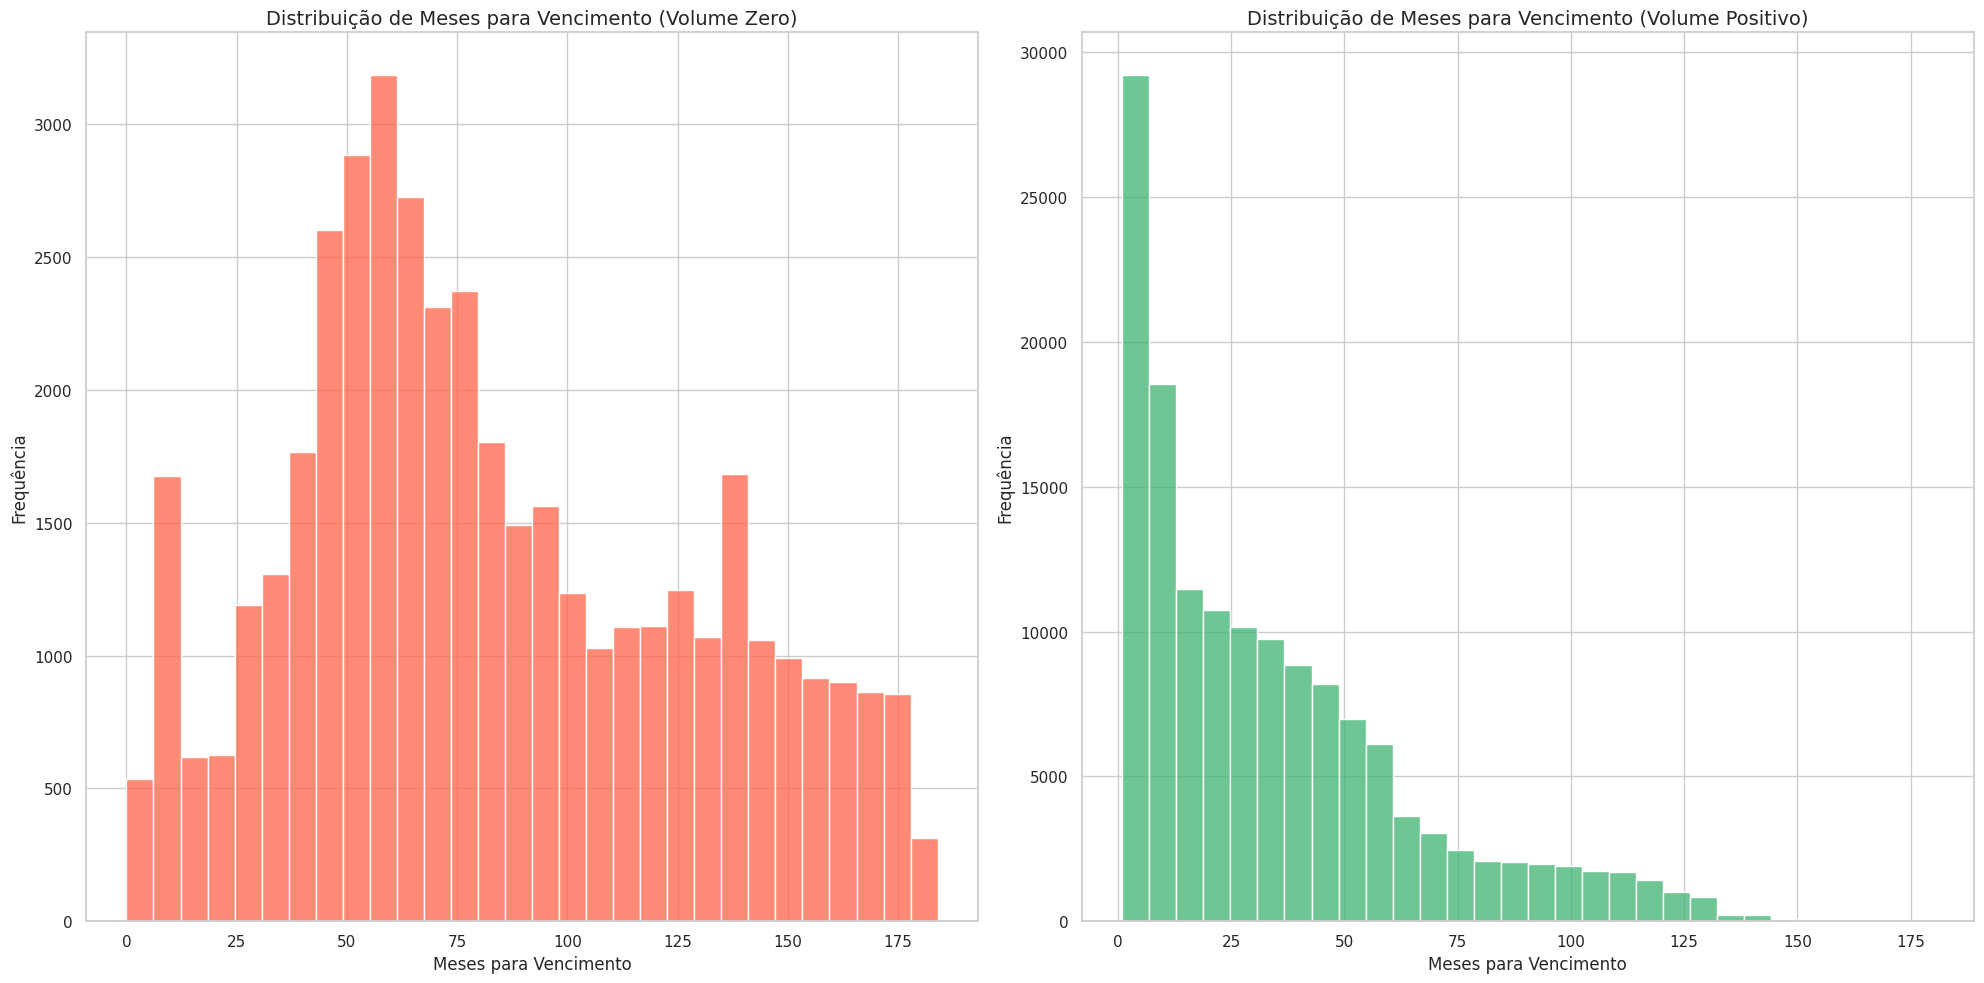

In [18]:
# Configurando o tamanho e o estilo da figura
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")

# Primeiro Subplot: Distribuição de Meses para Vencimento com Volume Zero
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
sns.histplot(df_vol_zero['meses_para_vencimento'], bins=30, kde=False, color='tomato')
plt.title('Distribuição de Meses para Vencimento (Volume Zero)', fontsize=14)
plt.xlabel('Meses para Vencimento', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Segundo Subplot: Distribuição de Meses para Vencimento com Volume Positivo
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
sns.histplot(df['meses_para_vencimento'], bins=30, kde=False, color='mediumseagreen')
plt.title('Distribuição de Meses para Vencimento (Volume Positivo)', fontsize=14)
plt.xlabel('Meses para Vencimento', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Ajustando o layout
plt.tight_layout()

# 13. Exibindo o gráfico
plt.show()


Neste bloco de código, foram gerados dois histogramas que proporcionam insights sobre a distribuição do tempo de vencimento dos contratos, separados por aqueles com volume zero e volume positivo.

- Histograma de Distribuição de Meses para Vencimento (Volume Zero):

O primeiro subplot ilustra a frequência de contratos com volume de negociação zero em relação ao número de meses até o vencimento. Observamos que a distribuição é relativamente uniforme com uma leve concentração em períodos mais distantes ao vencimento, sugerindo que contratos mais distantes ao vencimento podem ter uma tendência maior a não serem negociados, o que poderia estar relacionado a uma menor liquidez ou a outros fatores de mercado.

- Histograma de Distribuição de Meses para Vencimento (Volume Positivo):

O segundo subplot exibe a frequência de contratos com volume de negociação positivo em relação ao número de meses até o vencimento. Notamos que a maioria dos contratos com volume positivo concentra-se em períodos mais curtos até o vencimento, indicando que contratos com prazos de vencimento mais próximos tendem a ser mais negociados e, portanto, possuem maior liquidez.

- Comparação entre os Histogramas:

Comparando os dois histogramas, é evidente que a liquidez dos contratos varia com o tempo de vencimento. Enquanto os contratos sem atividade de negociação mostram uma distribuição mais ampla e menos concentrada, os contratos com atividade de negociação apresentam uma distribuição decrescente, com uma alta frequência de negociações concentrada em prazos mais curtos de vencimento. Este contraste reflete o comportamento típico do mercado de futuros, onde contratos mais próximos do vencimento geralmente são mais líquidos e, portanto, mais ativamente negociados.

### 5.3.6 - Análise de correlação

Agora, vamos realizar uma análise de correlação para entender as tendências lineares entre as atuais variáveis numéricas do dataset

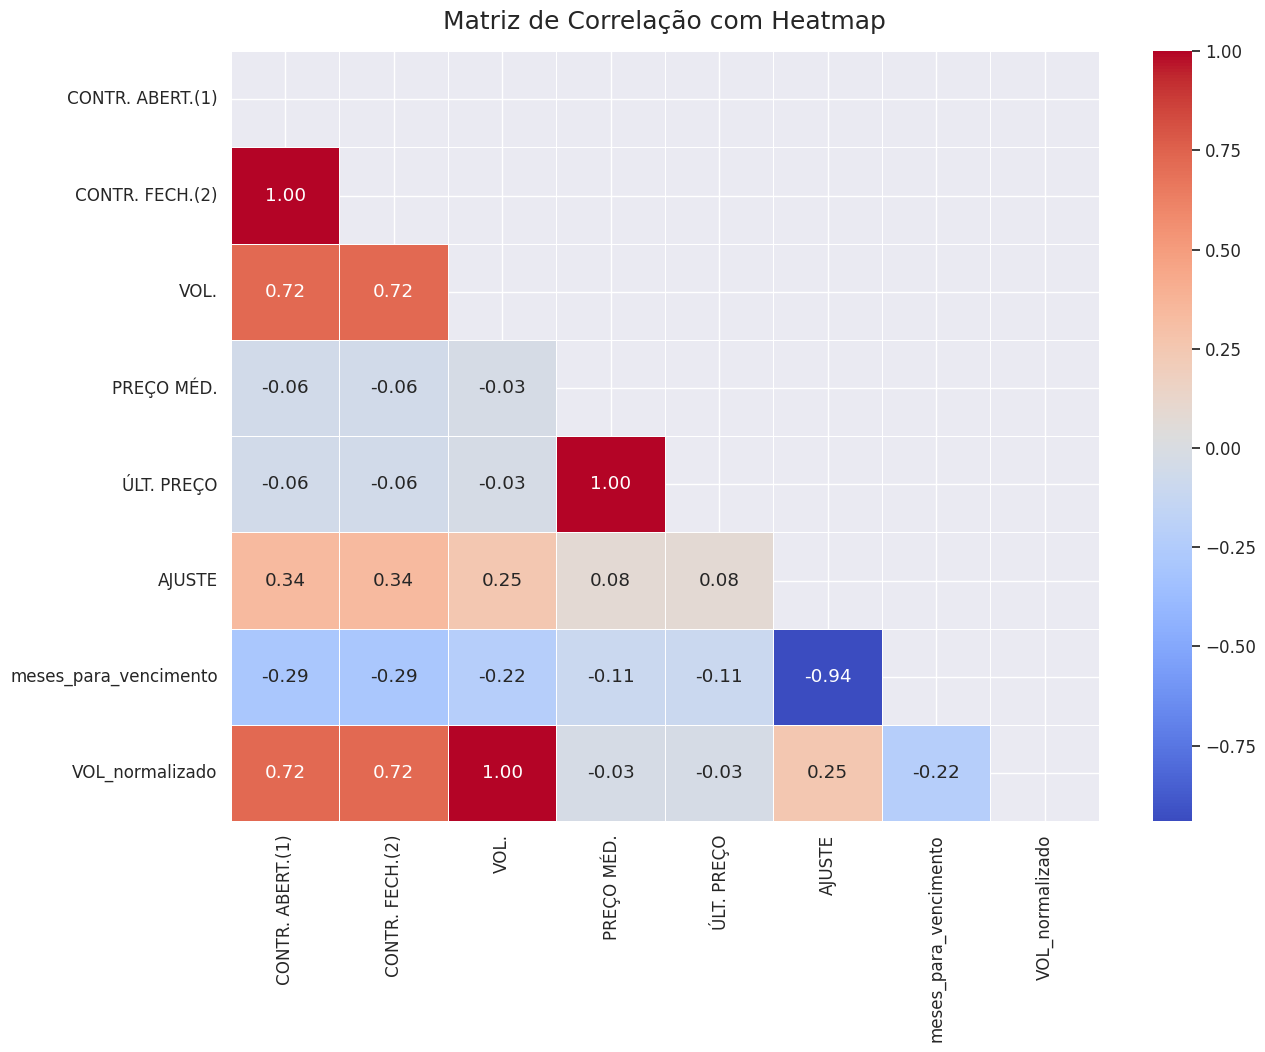

In [19]:
#Análise de correlação entre as variáveis atuais
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.1)  # Ajustar o tamanho da fonte
corr = df.select_dtypes(include=['float64', 'int64']).corr()
# 14. Criar uma máscara para ocultar o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
heatmap.set_title('Matriz de Correlação com Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

O gráfico de calor (heatmap) da matriz de correlação fornece uma perspectiva visual e quantitativa da relação linear entre as variáveis numéricas do nosso conjunto de dados.

- Correlação entre '**CONTR. ABERT.(1)**' e '**CONTR. FECH.(2)**': Correlação máxima (1,0) sugere que o número de contratos abertos e fechados estão fortemente alinhados, indicando que as aberturas e fechamentos dos contratos tendem a acontecer em volumes similares.

- Correlação com '**VOL.**': O volume de negociações apresenta uma correlação moderada (aproximadamente 0.72) com o número de contratos abertos e fechados, o que é esperado, já que mais contratos negociados devem corresponder a um volume de negociação maior.

- Correlação Negativa com '**meses_para_vencimento**': Há uma correlação negativa significativa (-0.94) entre o tempo até o vencimento e o ajuste, indicando que quanto mais próximo do vencimento, maior é o ajuste. Isso reflete justamente o comportamento dos preços dos contratos futuros à medida que se aproximam da data de vencimento.

- Correlações com '**PREÇO MÉD.**' e '**ÚLT. PREÇO**': Ambas as variáveis têm correlação máxima entre si (1.0) e correlação mínima com outras variáveis. Isso é esperado, pois o último preço do dia geralmente está próximo do preço médio.

- Correlação Negativa entre '**meses_para_vencimento**' e '**AJUSTE**': Uma forte correlação negativa (-0.94) sugere que, à medida que o vencimento de um contrato se aproxima, o ajuste tende a aumentar. Isso já era esperando, uma vez que o ajuste atinge o seu valor máxima de 100.000 no vencimento do contrato.

- Autocorrelação de '**VOL_normalizado**': Esta variável tem uma autocorrelação perfeita (1.0) com '**VOL.**', o que era de se esperar, já que é uma versão normalizada da mesma.

### 5.3.7 - Volume de negociação ao longo do tempo

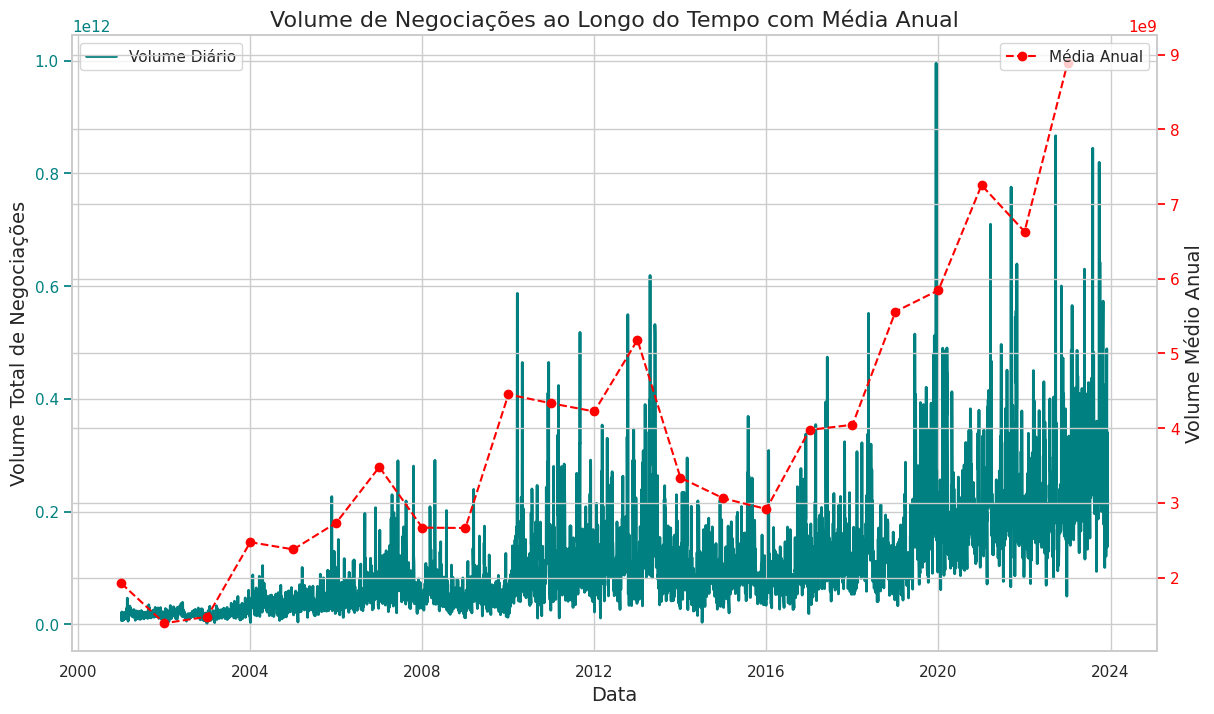

In [20]:
# Configuração inicial
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
# Calculando o volume total diário
volume_diario = df.groupby('Data')['VOL.'].sum()
# Calculando a média anual em uma série separada e ajustando o índice
volume_medio_anual = df.groupby(df['Data'].dt.year)['VOL.'].mean()
volume_medio_anual.index = pd.to_datetime(volume_medio_anual.index, format='%Y')
# Criando o gráfico principal para o volume total diário
ax1 = plt.gca()  # Obtendo o eixo atual
ax1.plot(volume_diario, label='Volume Diário', color='teal', linewidth=2)
ax1.set_xlabel('Data', fontsize=14)
ax1.set_ylabel('Volume Total de Negociações', fontsize=14)
ax1.tick_params(axis='y', colors='teal')
# Criando um eixo secundário para a média anual
ax2 = ax1.twinx()  # Criando um eixo secundário que compartilha o mesmo eixo x
ax2.plot(volume_medio_anual.index, volume_medio_anual, label='Média Anual', color='red', linestyle='--', marker='o')
ax2.set_ylabel('Volume Médio Anual', fontsize=14)
ax2.tick_params(axis='y', colors='red')
# 15. Ajustes finais do gráfico
plt.title('Volume de Negociações ao Longo do Tempo com Média Anual', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45, fontsize=12)
plt.show()

O gráfico apresentado compara o volume diário de negociações de contratos futuros com a média anual dessas negociações ao longo do tempo. O eixo principal (esquerdo) mostra o volume total diário, enquanto o eixo secundário (direito) destaca a média anual.

* Volume Diário: O gráfico mostra flutuações significativas no volume diário ao longo dos anos. As barras verticais indicam o volume de negociação para cada dia, com picos e vales destacando períodos de alta e baixa atividade no mercado.Entretanto, é possível enxergar uma clara tendência de aumento, ao longo do tempo.

* Média Anual: A linha vermelha pontilhada mostra a média anual do volume de negociações, proporcionando uma visão da tendência central ao longo do tempo. Esta linha suaviza as flutuações diárias e revela os padrões de longo prazo.

Assim, podemos enxergar que existe uma tendência de crescimento no volume de negociações ao longo dos anos, o que pode ser reflexo do aumento da atividade no mercado de contratos futuros, assim como de mudanças na economia. Também podemos ver que há períodos de volatilidade significativa, talvez em virtude de fatores como a sazonalidade. Isso pode ser resultado de eventos específicos do mercado ou de notícias econômicas que afetam a negociação de contratos futuros.

Em alguns momentos, a linha da média anual e o volume diário parecem convergir, indicando períodos de menor volatilidade e mais estabilidade nas negociações, porém vale destacar a discrepância entre as escalas do volume diário e da média anual sugere que os picos de negociação são eventos relativamente raros, mas com grande impacto no volume total.

Este tipo de visualização é valioso para identificar períodos de alta negociação, que podem ser correlacionados com eventos macroeconômicos ou mudanças no mercado, que não são contemplados no presente trabalho. Além disso, o aumento da atividade ao longo do tempo sugere que o mercado de contratos futuros está se tornando mais "quente". Estas informações podem ser úteis para o desenvolvimento de modelos preditivos, especialmente se considerarmos que um maior volume nas negociações busca uma maior tentativa de para compor a expectativa de uma taxa de juros futura, assim podendo melhor explicar a taxa Selic.

### 5.3.8 - Discretizando o tempo para vencimento em grupos



In [21]:
#Vamos discretizar a colna meses_para_vencimento criando a coluna grupos_de_vencimentos
# Definindo os limites dos intervalos em meses
bins = [-np.inf] + list(range(12, df['meses_para_vencimento'].max() + 12, 12))  # Começando de -infinito até o valor máximo de meses em intervalos de 12 meses
# Definindo os rótulos
labels = [f'{i} Ano' if i == 1 else f'{i} Anos' for i in range(1, len(bins))]
# Criando a coluna 'grupos_de_vencimentos'
df['grupos_de_vencimentos'] = pd.cut(df['meses_para_vencimento'], bins=bins, labels=labels, include_lowest=True)

# 16. Print das colunas de meses para vencimento e a de grupos de vencimentos
print(df[['meses_para_vencimento','grupos_de_vencimentos']])

        meses_para_vencimento grupos_de_vencimentos
1                           1                 1 Ano
2                           2                 1 Ano
3                           3                 1 Ano
4                           4                 1 Ano
5                           6                 1 Ano
...                       ...                   ...
187578                     73                7 Anos
187579                     85                8 Anos
187580                     97                9 Anos
187581                    109               10 Anos
187582                    121               11 Anos

[144548 rows x 2 columns]


Neste trecho prossegumos com a estratégia de discretizar a coluna **meses_para_vencimento** e criar a coluna **grupos_de_vencimentos**. Essa é uma forma de categorizar os contratos futuros de DI em grupos mais interpretáveis, que refletem a liquidez do contrato baseada no tempo restante até o seu vencimento.

Este processo também é útil para preceder a etapa de one-hot-encoding, afim de preparar o dataset para a etapa modelagem. Mas, por enquanto, vamos manter apenas a discretização para categorizar o vencimento em grupos e extrair insights.

Com essa estratégia nos poderemos:

- Facilitar a Análise: A conversão de dados contínuos em categorias pode simplificar a análise, facilitando a compreensão dos padrões e a comunicação dos resultados. Ao invés de lidar com um espectro amplo e contínuo de meses, os dados são divididos em intervalos anuais, que são mais fáceis de interpretar e analisar.

- Interpretação de Liquidez: Contratos com vencimentos mais próximos tendem a ser mais líquidos. Portanto, categorizar os contratos com base na liquidez pode ajudar a identificar como o volume de negociações e a volatilidade podem variar em diferentes horizontes de tempo.

- Aplicações Práticas: Com a criação da coluna **grupos_de_vencimentos**, torna-se possível realizar comparações diretas e análises entre grupos de contratos, o que vai ser útil para identificar tendências de mercado, realizar estudos de comportamento de preços e desenvolver estratégias de negociação.

### 5.3.9 - Cálculo da taxa de juros implícita e agregação da taxa Selic

A criação da coluna de taxa de juros implícita é uma etapa significativa na análise dos contratos futuros. Esta taxa reflete a expectativa do mercado quanto à taxa de juros em uma data futura, baseada no preço atual do contrato futuro de DI (Depósito Interfinanceiro). É um cálculo complexo que leva em conta o número de dias úteis entre a data de negociação e a data de vencimento do contrato, ajustado pelos feriados nacionais.

Além disso, vamos ajustar os primeiros valores nas colunas de Preço Médio e Último preço, uma vez que os dados mais antigos apresentam tais valores em termos gerais, não refletindo a taxa implicita como segue no final do dataset.

In [22]:
# Convertendo a coluna de data para datetime, erros serão transformados em NaT
df_feriados['Data'] = pd.to_datetime(df_feriados['Data'], format='%d/%m/%Y', errors='coerce')
# Removendo linhas onde a coluna de data é NaT (não é uma data válida)
df_feriados = df_feriados.dropna(subset=['Data'])
# Encontrando a primeira e a última data em df['VENCTO_EXPLICADO']
primeira_data = df['Data'].min()
ultima_data = df['VENCTO_EXPLICADO'].max()
# Filtrando df_feriados para o intervalo desejado
df_feriados = df_feriados[(df_feriados['Data'] >= primeira_data) & (df_feriados['Data'] <= ultima_data)]
# Convertendo a coluna de data de feriados para o formato numpy datetime64
feriados_array = df_feriados['Data'].values.astype('datetime64[D]')

# Criando a coluna de Taxa de juros implicita com base no valor de ajuste
df['Taxa_Juros_Implícita'] = df.apply(lambda row: calcular_taxa_juros_implicita(row['AJUSTE'], row['Data'], row['VENCTO_EXPLICADO'], feriados_array), axis=1)

# Ajustando as colunas de Preço Médio e Último Preço

# Identificar o ponto de corte onde a magnitude dos números muda
# Assumindo que valores acima de 100 indicam o formato antigo (como ajuste), uma vez que não há indicios de taxas de juros passadas ou expectativas superiores a 100% na história do Brasil
ponto_corte_preco_med = df[df['PREÇO MÉD.'] > 100].last_valid_index()
ponto_corte_ult_preco = df[df['ÚLT. PREÇO'] > 100].last_valid_index()

# Encontrar o menor índice (mais antigo) entre os dois
ponto_corte_final = min(ponto_corte_preco_med, ponto_corte_ult_preco)

# Aplicar a função de cálculo da taxa de juros implícita até o ponto de corte
if ponto_corte_final:
    df.loc[:ponto_corte_final, 'PREÇO MÉD.'] = df.loc[:ponto_corte_final].apply(lambda row: calcular_taxa_juros_implicita(row['PREÇO MÉD.'], row['Data'], row['VENCTO_EXPLICADO'], feriados_array), axis=1)
    df.loc[:ponto_corte_final, 'ÚLT. PREÇO'] = df.loc[:ponto_corte_final].apply(lambda row: calcular_taxa_juros_implicita(row['ÚLT. PREÇO'], row['Data'], row['VENCTO_EXPLICADO'], feriados_array), axis=1)

# 17. Verificando novamente as primeiras e últimas linhas do dataset após as transformações
primeiras_linhas = df.head(15)
ultimas_linhas = df.tail(15)
print("\nPrimeiras Linhas do Dataset:\n", primeiras_linhas)
print("\nÚltimas Linhas do Dataset:\n", ultimas_linhas)


Primeiras Linhas do Dataset:
    VENCTO  CONTR. ABERT.(1)  CONTR. FECH.(2)         VOL.  PREÇO MÉD.  ÚLT. PREÇO    AJUSTE       Data VENCTO_EXPLICADO  meses_para_vencimento  VOL_normalizado  Grupo_Volume grupos_de_vencimentos  Taxa_Juros_Implícita
1     G01            135828           138253    674755900   15.697543   15.685866  98735.00 2001-01-02       2001-02-01                      1         0.001062  Baixo Volume                 1 Ano             15.699288
2     H01             34238            34803    217592465   15.739367   15.780719  97701.00 2001-01-02       2001-03-01                      2         0.000342  Baixo Volume                 1 Ano             15.780719
3     J01            228916           230739   1303147560   15.786366   15.849814  96446.54 2001-01-02       2001-04-01                      3         0.002051  Baixo Volume                 1 Ano             15.842296
4     K01                 0              100      9532000   15.870003   15.870003  95299.00 2001-

**Processo de Criação da Coluna de Taxa de Juros Implícita:**

- Preparação dos Feriados: Primeiramente, os dados de feriados são convertidos para o formato datetime e filtrados para o intervalo de datas que engloba as datas de negociação e vencimento dos contratos.

- Cálculo da Taxa Implícita: Utiliza-se a função **calcular_taxa_juros_implicita**, aplicada a cada linha do dataframe. Esta função calcula a taxa de juros implícita considerando o ajuste diário do contrato, a data de negociação, a data de vencimento e os feriados. O resultado é uma série de valores percentuais que representam a expectativa do mercado para a taxa de juros em cada vencimento.

**Ajuste das Colunas de Preço Médio e Último Preço:**

- Identificação do Ponto de Corte: Antes de aplicar a função de cálculo de taxa de juros implícita, é necessário identificar o ponto de corte onde os dados transitam de valores absolutos para representações de taxas. Assumindo que valores acima de 100 representam o formato antigo (semelhante ao ajuste), o script procura pelo último índice onde o Preço Médio e o Último Preço excedem essa magnitude. Esta abordagem é adequada considerando o contexto econômico do Brasil, onde taxas de juros acima de 100% são historicamente improváveis.

- Aplicação da Função de Cálculo: Com o ponto de corte identificado, a função **calcular_taxa_juros_implicita** é aplicada às colunas de Preço Médio e Último Preço até esse ponto. Isso transforma esses valores, inicialmente em formato de preço, para a representação da taxa de juros implícita. Esse ajuste é crucial, pois unifica as representações dos preços ao longo do tempo, permitindo uma análise consistente e comparável entre todos os registros do dataset.

- Verificação Pós-transformação: Após a aplicação da função, um controle de qualidade é feito ao examinar as primeiras e últimas linhas do dataframe. Isso garante que a transformação foi realizada corretamente e que os dados estão agora em um formato adequado para análises subsequentes.

### 5.3.10 - Gráficos de dispersão entre a coluna de Ajuste e os demais atributos

Nesta seção, concentramo-nos em criar gráficos de dispersão entre a coluna de Ajuste e os demais atributos numéricos do dataset, segmentando os grupos de acordo com o tempo para o vencimento dos contratos. Esta análise é crucial, uma vez que o preço de ajuste possui uma forte implicação nas expectativas do mercado sobre a evolução futura das taxas de juros. Ao visualizar como o Ajuste se relaciona com outras variáveis-chave, podemos extrair insights valiosos sobre o comportamento do mercado e a dinâmica dos contratos futuros.

A escolha de explorar estas relações por meio de gráficos de dispersão se dá pela capacidade deste tipo de gráfico em ilustrar os padrões potenciais entre duas variáveis. Por exemplo, um alinhamento ou uma tendência clara nos pontos pode indicar uma correlação positiva ou negativa. Além disso, ao colorir os pontos baseando-se no tempo para o vencimento dos contratos, obtemos uma camada adicional de informação que pode revelar como este fator influencia a relação entre o Ajuste e outras variáveis.


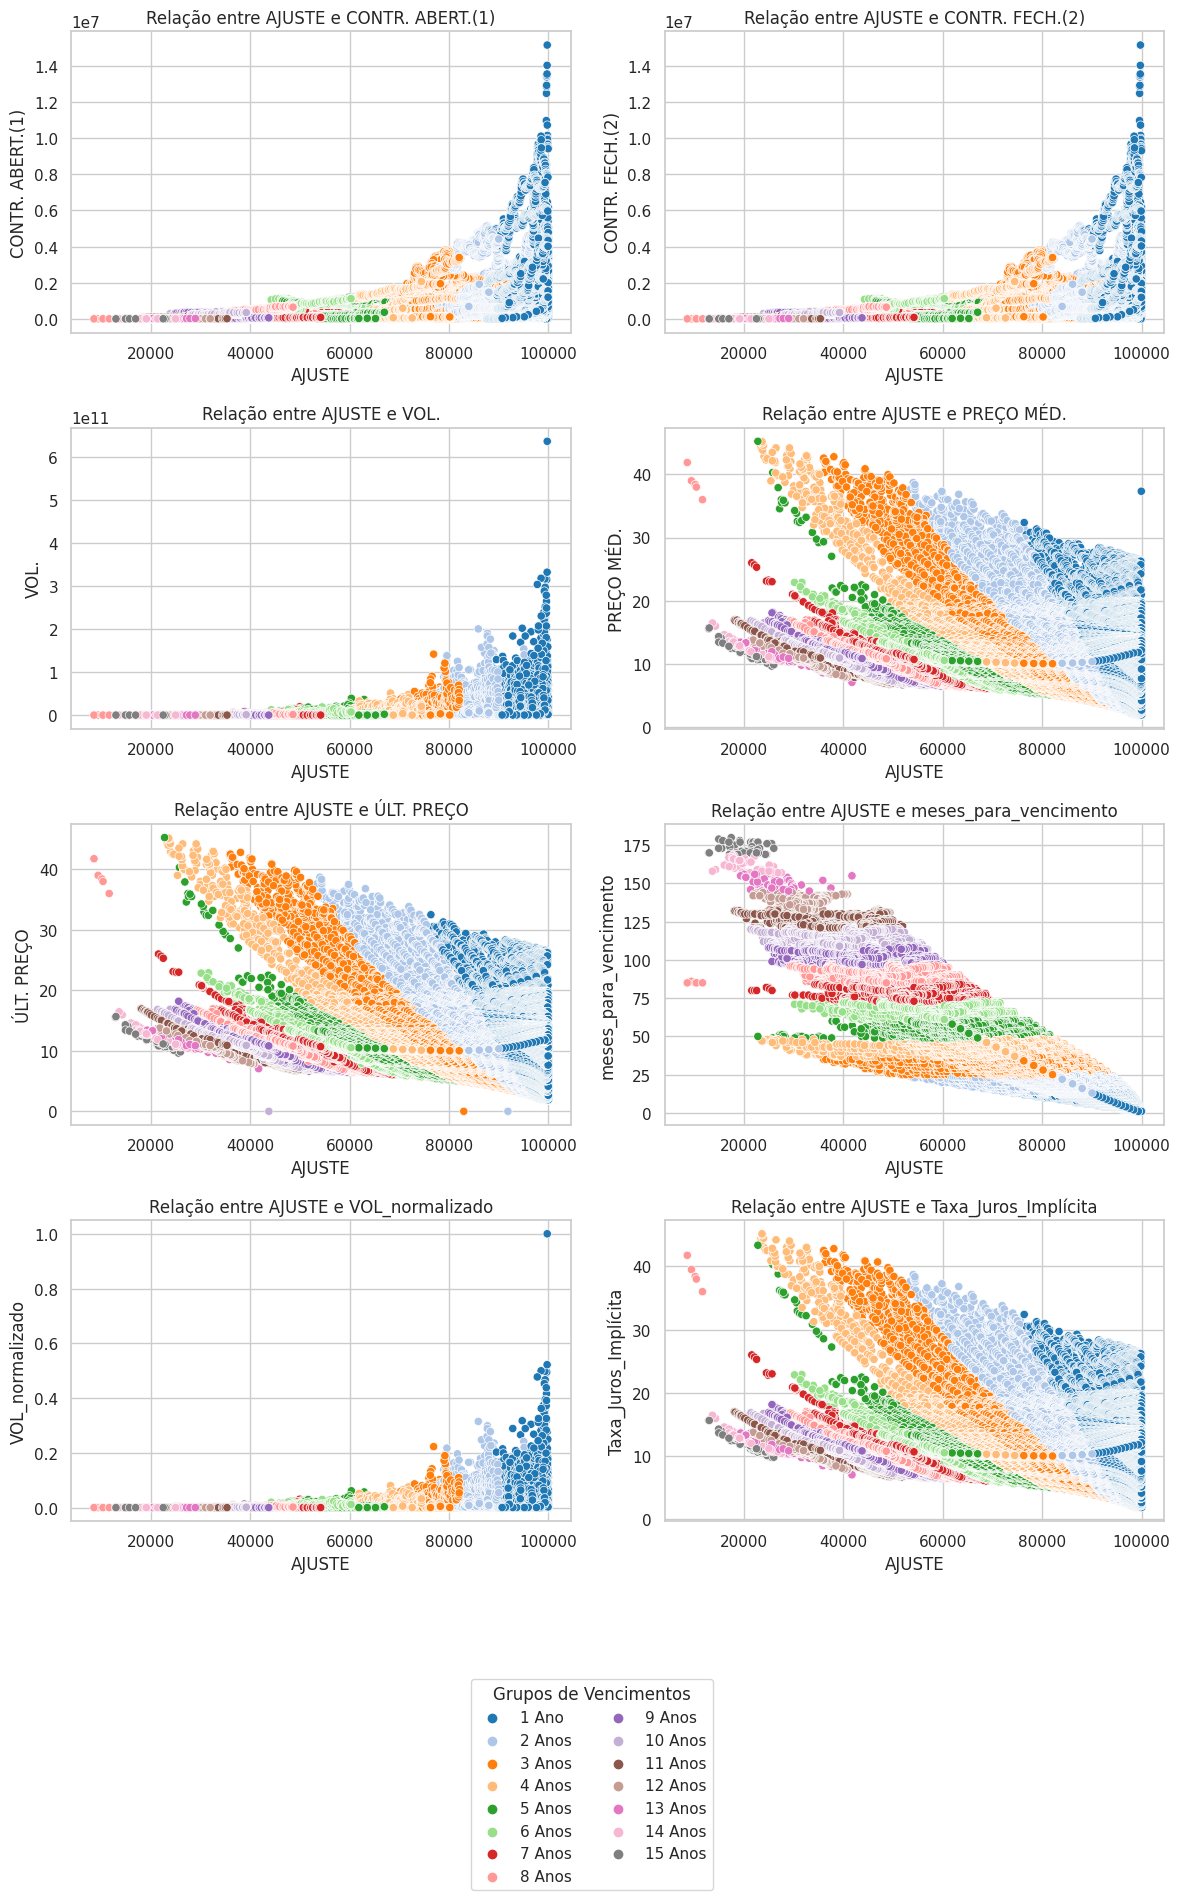

In [23]:
#Relação de ajuste com as demais variáveis
# Definindo as colunas numéricas (excluindo 'AJUSTE' para não comparar com ele mesmo)
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.drop('AJUSTE')
# Definindo o número de gráficos (um para cada coluna numérica, exceto 'AJUSTE')
n_graficos = len(colunas_numericas)
n_colunas = 2  # Número de colunas de subplots
n_linhas = n_graficos // n_colunas + (n_graficos % n_colunas > 0)  # Calcular número de linhas necessárias
# Criando um grid de subplots
fig, axes = plt.subplots(n_linhas, n_colunas, figsize=(12, 4 * n_linhas))
# Achatando o array de eixos para iterar facilmente
axes = axes.flatten()
# Iterando sobre cada coluna numérica e criando um scatter plot
for i, coluna in enumerate(colunas_numericas):
    sns.scatterplot(x=df['AJUSTE'], y=df[coluna], hue=df['grupos_de_vencimentos'], palette='tab20', ax=axes[i])
    axes[i].set_title(f'Relação entre AJUSTE e {coluna}')
    axes[i].set_xlabel('AJUSTE')
    axes[i].set_ylabel(coluna)
    axes[i].get_legend().remove()  # Removendo a legenda individual
# Adicionando uma legenda centralizada fora do gráfico, no canto inferior direito
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), title='Grupos de Vencimentos', ncol=2)

# 18. Escondendo os eixos extras se houver
for i in range(n_graficos, len(axes)):
    axes[i].set_visible(False)
# Ajustando o layout para dar espaço à legenda externa
plt.subplots_adjust(bottom=0.05)
plt.tight_layout()
plt.show()

Este trecho do trabalho visa explorar a relação entre a coluna '**AJUSTE**' e outras variáveis numéricas do dataframe, utilizando gráficos de dispersão (scatter plots) para visualizar essas relações. Para tal, foi feito:

- Seleção de Colunas Numéricas: Primeiro, seleciona-se todas as colunas numéricas do dataframe, excluindo a coluna '**AJUSTE**', para evitar a comparação com ela mesma.

- Criação de Subplots: O número de gráficos é definido com base no número de colunas numéricas selecionadas, organizando-os em um grid com duas colunas de subplots.

- Geração dos Gráficos de Dispersão: Para cada variável numérica, um gráfico de dispersão é criado, mostrando a relação dessa variável com a coluna '**AJUSTE**'. A coluna 'grupos_de_vencimentos' é usada para colorir os pontos, oferecendo uma visão adicional sobre como o tempo para o vencimento dos contratos se relaciona com '**AJUSTE**' e outras variáveis.

- Configuração da Legenda e Ajustes de Layout: A legenda é centralizada fora do gráfico, no canto inferior central, para não sobrepor qualquer parte dos subplots. O layout é ajustado para acomodar todos os elementos de forma clara e legível.

Relação entre o Ajuste e as quantidades de contratos abertos (**CONTR. ABERT.(1)**) e contratos fechados (**CONTR. FECH.(2)**):

- Concentração de Dados: Existe uma concentração de dados na extremidade superior do eixo do ajuste, sugerindo que a maior parte dos contratos é negociada com ajustes maiores.

- Padrão de Dispersão: À medida que o valor de ajuste aumenta, a quantidade de contratos tanto abertos quanto fechados também aumenta, indicando uma possível correlação positiva. No entanto, a dispersão dos pontos sugere que outros fatores podem influenciar o número de contratos abertos e fechados além do ajuste.

- Contratos com Liquidez Diferente: Os pontos mais próximos à origem do gráfico (ajuste baixo) tendem a ter uma variedade menor de liquidez, enquanto os pontos com ajustes mais altos são predominantemente associados a contratos com maior liquidez (mais próximos do vencimento). Isso pode indicar que, à medida que os contratos se aproximam do vencimento, o ajuste tende a ser maior devido à menor incerteza em relação à taxa de juros futura.

- Outliers: Existem outliers claros, especialmente no extremo direito dos gráficos, onde os valores de ajuste são muito altos. Isso pode indicar dias específicos de alta volatilidade ou movimentações atípicas no mercado.

Relação entre o Ajuste e o volume (**VOL.** e **VOL_normalizado**):

 - Nos gráficos que comparam o ajuste com o volume de negociações, observamos que, para a maior parte dos pontos, o volume aumenta com o ajuste, mas o relacionamento não parece linear. A relação mostra uma tendência de crescimento exponencial, com alguns dias mostrando um volume extraordinariamente alto, o que é representado pelos pontos no extremo superior do gráfico. Estes podem indicar dias de notícias significativas ou eventos de mercado que impulsionaram um volume de negociações excepcionalmente alto. Os ajustes de contratos com maior liquidez também aparecem concentrados na porção direita do gráfico, mostrando que uma maior liquidez está associada a um preço de ajuste mais elevado.

Relação entre o Ajuste e Preço Médio, Último preço e taxa de juros implícita (**PREÇO MÉD.**, **ÚLT.PREÇO** e **Taxa_juros_implícita**):

 - Os gráficos que mostram a relação entre ajuste com preço médio, último preço e taxa de juros implícita apresentam um padrão interessante de bandas diagonais descendentes. Isso sugere que, para cada nível de ajuste, existe uma faixa de preços e taxas possíveis, que se reduzem à medida que o ajuste aumenta. Este padrão pode ser uma característica dos contratos de DI futuros, onde esses valores e o ajuste são inversamente relacionados, refletindo a mecânica de como os preços dos contratos futuros são determinados em função das expectativas de taxas de juros futuras.

Relação entre o Ajuste e Meses para Vencimento (**meses_para_vencimento**):

 - Há uma clara relação inversa entre o ajuste e o tempo para vencimento. Conforme o tempo para o vencimento aumenta, o valor do ajuste tende a diminuir.A maioria dos pontos está concentrada em ajustes mais baixos com tempos de vencimento mais longos. É possível notar também que à medida que nos aproximamos do vencimento (menos meses para o vencimento), os dados tornam-se menos dispersos e o ajuste apresenta menor variação, o que é corente já que o preço de ajuste no vencimento é de 100.000. Por fim, podemos ver também que os contratos com mais tempo até o vencimento tendem a ter preços de ajuste mais voláteis, enquanto contratos com mais próximos do vencimento mostram maior estabilidade no ajuste.

### 5.3.11 - Análise de componentes principais (PCA)

A Análise de Componentes Principais (PCA) é uma técnica estatística usada para revelar a estrutura fundamental dos dados através da redução de dimensionalidade. Embora comumente aplicada para simplificar dados com muitas variáveis, neste trabalho, a PCA será explorada com o intuito de compreender quais características contribuem mais para a variabilidade no nosso conjunto de dados. Ao identificar as principais componentes, podemos discernir padrões ocultos e entender as direções de maior variação nos dados.

Variância explicada por cada componente: [0.50711127 0.32330202]


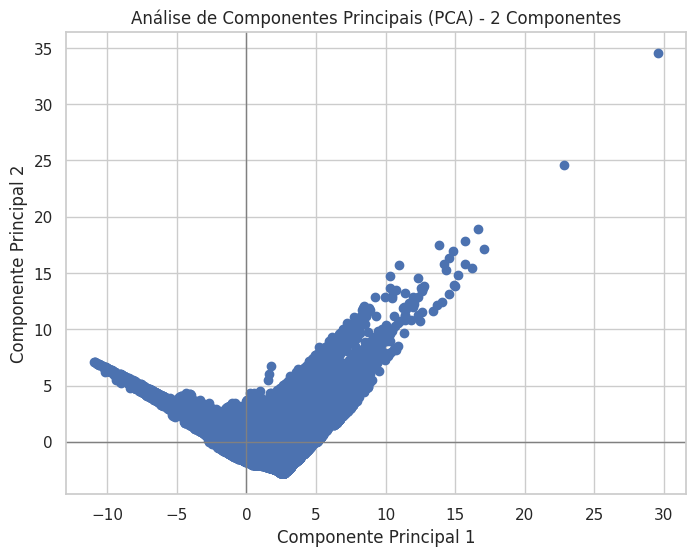

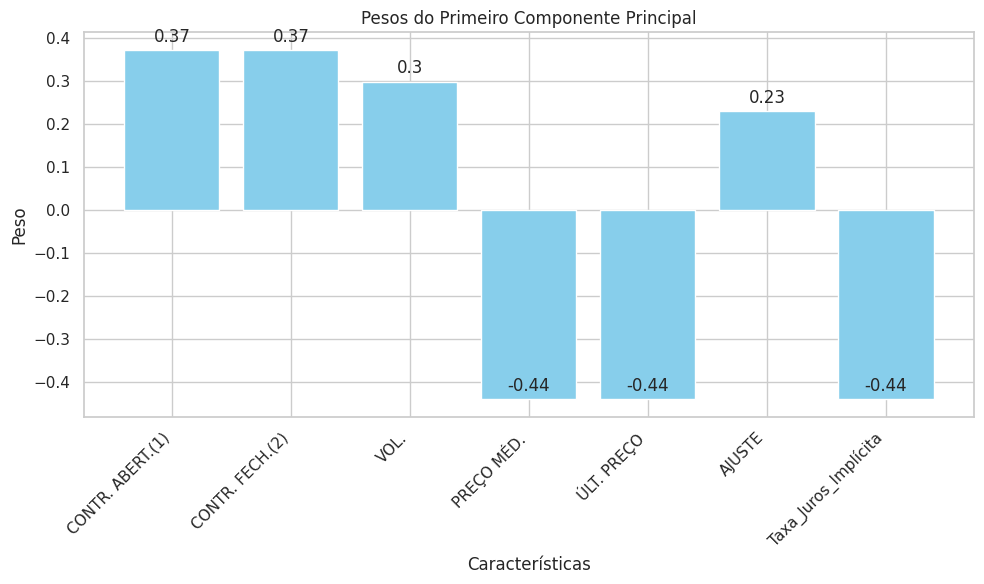

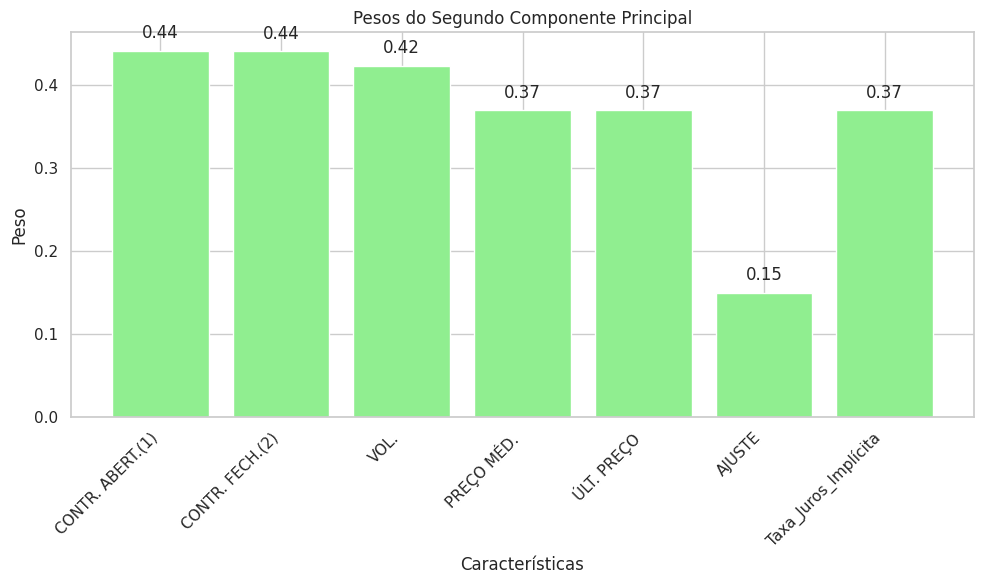

In [24]:
# Features selecionadas para o PCA
features = ['CONTR. ABERT.(1)', 'CONTR. FECH.(2)', 'VOL.', 'PREÇO MÉD.', 'ÚLT. PREÇO', 'AJUSTE', 'Taxa_Juros_Implícita']
# Separar as características
X = df.loc[:, features].values

# Padronizar os dados
X_std = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)  # n_components é o número de componentes a manter
principalComponents = pca.fit_transform(X_std)

# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Criar um DataFrame com os componentes principais
principalDf = pd.DataFrame(data=principalComponents, columns=['Componente Principal 1', 'Componente Principal 2'])

# 19. Exibindo a variância explicada
print("Variância explicada por cada componente:", explained_variance)

# 20. Visualização
plt.figure(figsize=(8, 6))
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Análise de Componentes Principais (PCA) - 2 Componentes')
plt.scatter(principalDf['Componente Principal 1'], principalDf['Componente Principal 2'])
plt.axvline(0, color='grey', lw=1)
plt.axhline(0, color='grey', lw=1)
plt.grid(True)
plt.show()

# Extraindo os componentes principais
componentes_principais = pca.components_

# Nomeando os componentes principais
nomes_componentes = [f"Componente {i+1}" for i in range(pca.n_components_)]

# 21. Visualizando os pesos (loadings) do primeiro componente principal
plt.figure(figsize=(10, 6))
barras = plt.bar(features, componentes_principais[0], color='skyblue')
plt.xlabel('Características')
plt.ylabel('Peso')
plt.title('Pesos do Primeiro Componente Principal')
plt.xticks(rotation=45, ha='right')

# Adicionando os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 22. Visualizando os pesos (loadings) do segundo componente principal
plt.figure(figsize=(10, 6))
barras = plt.bar(features, componentes_principais[1], color='lightgreen')
plt.xlabel('Características')
plt.ylabel('Peso')
plt.title('Pesos do Segundo Componente Principal')
plt.xticks(rotation=45, ha='right')

# Adicionando os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

O bloco de código para a Análise de Componentes Principais (PCA) segue uma abordagem padrão para redução de dimensionalidade em dados multidimensionais. Primeiro, selecionamos um conjunto de características relevantes que queremos analisar. Estas características são então padronizadas usando `StandardScaler` para garantir que cada característica contribua igualmente para o resultado sem ser enviesada pela escala dos dados.

O PCA é aplicado para transformar essas características padronizadas em componentes principais, reduzindo assim a dimensionalidade dos dados para os dois principais componentes que capturam a maior parte da variância nos dados. A variância explicada por cada componente é impressa, oferecendo uma visão da quantidade de informação que cada componente carrega.

As visualizações geradas incluem um gráfico de dispersão dos dois componentes principais e gráficos de barras para os pesos de cada característica nos dois principais componentes.

* Variância explicada por cada componente:

Os valores **[0.50711127 0.32330202]** indicam a porcentagem da variância total dos dados que é explicada por cada um dos dois primeiros componentes principais.

**Primeiro Componente** (0.50711127 ou cerca de 51%): Este valor significa que aproximadamente 51% da variância total dos dados é explicada pelo primeiro componente principal.

**Segundo Componente** (0.32330202 ou cerca de 32%): Este valor indica que cerca de 32% da variância total é explicada pelo segundo componente principal.

**Interpretação**: Juntos, esses dois componentes explicam aproximadamente 83% (51% + 32%) da variância total dos dados. Isso é uma indicação de que esses dois componentes capturam a maioria das informações presentes no conjunto de dados original.  

* Gráfico de dispersão entre os componentes:

Observando o gráfico, podemos ver que existe uma concentração de pontos ao redor do eixo do Componente Principal 1, estendendo-se para valores positivos mais elevados. Isso indica que o Componente Principal 1 é significativo para a variabilidade dos dados.

Há também uma distribuição alongada ao longo do Componente Principal 2, mas a variabilidade é menos pronunciada em comparação com o Componente Principal 1, como também foi refletido pela proporção de variância explicada (32.33% pelo segundo componente versus 50.71% pelo primeiro).

Os pontos que se desviam para valores mais elevados em ambos os componentes podem representar dados atípicos ou padrões específicos que diferem da tendência geral dos dados.

A maioria dos pontos está concentrada em torno da origem, que é o ponto (0,0) no gráfico. Isso indica que muitos dos dados compartilham características comuns que são capturadas pelos componentes principais.

* Observações para o **primeiro** componente principal:

'**CONTR. ABERT.(1)**' e '**CONTR. FECH.(2)**' têm pesos positivos fortes (0.37), o que indica que um alto número de contratos abertos e fechados contribui significativamente para este componente.

'**VOL.**' também tem um peso positivo (0.30), o que sugere que o volume de negociações é uma característica importante para este componente, mas com uma contribuição um pouco menor em comparação com o número de contratos.

'**PREÇO MÉD.**', '**ÚLT. PREÇO**' e '**Taxa_Juros_Implícita**' têm pesos negativos fortes (-0.44), indicando que essas características têm uma relação inversa com o primeiro componente principal. Ou seja, quanto maior esses valores, menor a pontuação do componente principal, o que pode refletir uma expectativa de menores taxas de juros.

'**AJUSTE**' tem um peso positivo (0.23), mas não é tão pronunciado quanto outros pesos, indicando uma influência moderada neste componente principal.

* Observações para o **segundo** componente principal:

Todos os pesos são positivos, com '**CONTR. ABERT.(1)**', '**CONTR. FECH.(2)**', e '**VOL.**' tendo os maiores pesos (0.44, 0.44, e 0.42, respectivamente), o que sugere que essas características são os principais drivers para o segundo componente principal.

'**PREÇO MÉD.**', '**ÚLT. PREÇO**', e '**Taxa_Juros_Implícita**' têm pesos consideráveis também (0.37), mostrando que essas características ainda contribuem significativamente para este componente.

'**AJUSTE**' tem o menor peso (0.15), indicando que tem a menor influência sobre a variabilidade capturada pelo segundo componente principal.

* Conclusões:

A partir desses pesos, podemos interpretar que o primeiro componente principal pode estar capturando uma espécie de 'tamanho' ou 'escala' do mercado, onde contratos com volumes maiores e mais abertos e fechados têm maior influência. O segundo componente principal, por sua vez, parece estar capturando uma variação diferente, possivelmente a dinâmica de preços e taxas de juros, já que todos os pesos são positivos e as características relacionadas ao preço e taxa têm um peso significativo.

### 5.3.12 - Agregação da Taxa Selic ao dataset

A agregação da taxa Selic ao nosso conjunto de dados representa um passo crucial de enriquecimento de dados para a nossa análise, criando um ponto de comparação entre as taxas de juros implícitas, derivadas dos dados do mercado de contratos futuros, e a taxa de juros estabelecida pela política monetária oficial. Ao alinhar as taxas de juros implícitas calculadas com a taxa Selic correspondente à data de vencimento de cada contrato, podemos começar a desvendar as relações e as discrepâncias entre as expectativas do mercado e as decisões de política monetária.

In [25]:
# 23. Verificando as primeiras linhas do dataset selic
primeiras_linhas_selic = df_selic.head(15)
ultimas_linhas_selic = df_selic.tail(15)
print("\nPrimeiras Linhas do Dataset:\n", primeiras_linhas_selic)
print("\nÚltimas Linhas do Dataset:\n", ultimas_linhas_selic)


Primeiras Linhas do Dataset:
           Data 1178 - Taxa de juros - Selic anualizada base 252 - % a.a.
0   02/01/2001                                              15,85       
1   03/01/2001                                              15,79       
2   04/01/2001                                              15,83       
3   05/01/2001                                              15,80       
4   08/01/2001                                              15,80       
5   09/01/2001                                              15,80       
6   10/01/2001                                              15,66       
7   11/01/2001                                              15,65       
8   12/01/2001                                              15,65       
9   15/01/2001                                              15,65       
10  16/01/2001                                              15,65       
11  17/01/2001                                              15,59       
12  18/01/2001      

In [26]:
# Removendo a última linha do DataFrame df_selic
df_selic = df_selic.iloc[:-1]
# Certifique-se de que a coluna 'Data' em ambos os DataFrames está no formato correto
df_selic['Data'] = pd.to_datetime(df_selic['Data'], format='%d/%m/%Y')
# Renomeie a coluna de taxa SELIC para algo mais descritivo
df_selic.rename(columns={'1178 - Taxa de juros - Selic anualizada base 252 - % a.a.': 'Taxa_SELIC'}, inplace=True)
# Convertendo a taxa SELIC para o formato numérico correto e renomeando a coluna de data
df_selic['Taxa_SELIC'] = df_selic['Taxa_SELIC'].str.replace(',', '.').astype(float)
df_selic.rename(columns={df_selic.columns[0]: 'Data_SELIC'}, inplace=True)

# Garantindo que os DataFrames estão ordenados por data
df.sort_values(by='VENCTO_EXPLICADO', inplace=True)
df_selic.sort_values(by='Data_SELIC', inplace=True)

# Realizando o merge_asof com direction='nearest'
df = pd.merge_asof(df, df_selic, left_on='VENCTO_EXPLICADO', right_on='Data_SELIC', direction='nearest')
df.drop(columns=['Data_SELIC'], inplace=True)

# Preenchendo com NaN onde a data de vencimento é posterior à última data da SELIC
ultima_data_selic = df_selic['Data_SELIC'].max()
df['Taxa_SELIC'] = df.apply(lambda row: row['Taxa_SELIC'] if row['VENCTO_EXPLICADO'] <= ultima_data_selic else np.nan, axis=1)

# 24. Dados estatísticos da Taxa Selic no dataframe
print(df['Taxa_SELIC'].describe())

count    119979.000000
mean         10.570122
std           4.668860
min           1.900000
25%           6.900000
50%          10.900000
75%          13.650000
max          26.320000
Name: Taxa_SELIC, dtype: float64



Inicialmente, a última linha do DataFrame da Selic é removida pois ela apresenta somente um dado explicativo sobre a série temporal. As datas nos dois DataFrames são então padronizadas para garantir consistência no formato. A coluna da taxa Selic é renomeada para ser mais descritiva e é convertida para um formato numérico, permitindo os cálculos futuros. Após isso, ambos os DataFrames são ordenados por data para garantir a correta correspondência durante o processo de mesclagem.

A função `pd.merge_asof` é usada para combinar os dois DataFrames baseando-se na proximidade das datas de vencimento com as datas da taxa Selic. O parâmetro `direction='nearest'` assegura que, para cada data de vencimento, seja associada a taxa Selic mais próxima disponível. Isso é especialmente útil para contratos que não têm uma taxa Selic exatamente na mesma data de vencimento. As linhas onde a data de vencimento é posterior à última data da Selic disponível são preenchidas com `NaN`, pois não há taxa correspondente para o a data de vencimento desses contratos.

A saída do método `describe` fornece uma visão estatística do conjunto de dados da taxa Selic após o `merge`. Observamos que a taxa Selic tem uma média aproximada de 10.57% ao ano, com um desvio padrão de 4.67, indicando variabilidade substancial ao longo do tempo. A taxa mínima registrada foi de 1.9%, enquanto a máxima foi de 26.32%. Isso reflete o espectro de políticas monetárias adotadas pelo Banco Central ao longo dos 22 anos em resposta a diferentes condições econômicas. Essas estatísticas serão fundamentais para análises comparativas subsequentes entre a taxa Selic oficial e as expectativas do mercado refletidas nas taxas de juros implícitas dos contratos futuros de DI.

### 5.3.13 - Relação entre as Taxas Implícitas calculadas e a Taxa Selic

As análises seguintes visam entender profundamentes as relações entre as taxas de juros implícitas calculadas e a taxa selic.

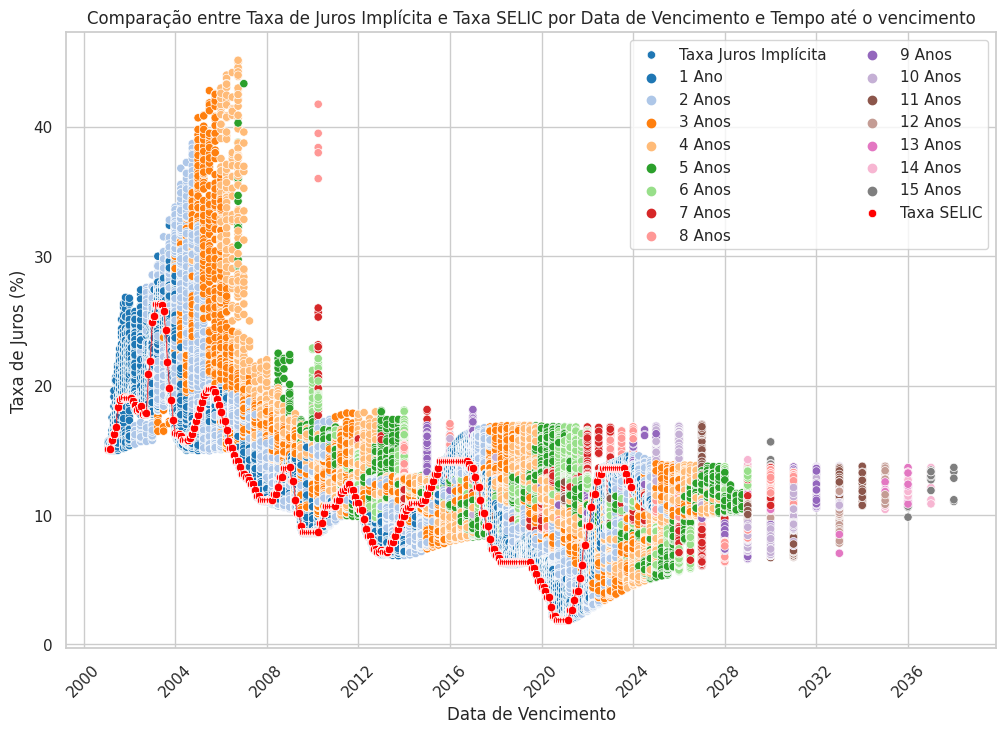

In [27]:
# Definindo o estilo do gráfico
sns.set(style="whitegrid")

# Criando o gráfico de dispersão
plt.figure(figsize=(12, 8))
# Plotando a Taxa de Juros Implícita
scatter = sns.scatterplot(x='VENCTO_EXPLICADO', y='Taxa_Juros_Implícita', data=df,
                          hue='grupos_de_vencimentos', palette='tab20',
                          label='Taxa Juros Implícita')

# Plotando a Taxa SELIC como 'x'
sns.scatterplot(x='VENCTO_EXPLICADO', y='Taxa_SELIC', data=df, color='red', label='Taxa SELIC')
# Interligando os pontos da Taxa SELIC com uma linha mais fina
sns.lineplot(x='VENCTO_EXPLICADO', y='Taxa_SELIC', data=df, color='red', linewidth=0.4)

# Adicionando títulos e rótulos
plt.title('Comparação entre Taxa de Juros Implícita e Taxa SELIC por Data de Vencimento e Tempo até o vencimento')
plt.xlabel('Data de Vencimento')
plt.ylabel('Taxa de Juros (%)')
plt.xticks(rotation=45)
# Ajustando a legenda para duas colunas
plt.legend(ncol=2)

# 25. Exibindo o gráfico
plt.show()

O código começa definindo o estilo do gráfico para garantir uma apresentação visual consistente. Utilizando a biblioteca `Seaborn`, um gráfico de dispersão é criado para visualizar duas métricas chave: a taxa de juros implícita calculada para os contratos de DI e a taxa Selic oficial. As taxas implícitas são plotadas com uma gama de cores que representam o tempo para o vencimento dos contratos, facilitando a visualização de como esta variável pode afetar a proximidade das taxas implícitas com a Selic.

A taxa Selic é destacada em vermelho para contraste, e uma linha é traçada para interligar seus pontos, fornecendo uma referência visual clara do comportamento da taxa ao longo do tempo em relação às datas de vencimento dos contratos. O eixo x é marcado com as datas de vencimento, e o eixo y mostra as taxas de juros em percentual.

Como já reparamos anteriormente, o agrupamento pelo tempo para o vencimento é um fator extremamente importante para entender como os dados do nosso dataset se distribuem.

Analisando o gráfico, percebe-se que contratos com vencimentos mais próximos tendem a ter taxas implícitas que mais se alinham com a taxa Selic, o que sugere maior precisão ou confiança nas expectativas do mercado para o curto prazo. Em contrapartida, contratos com vencimentos mais distantes exibem maior variação em relação à taxa Selic, refletindo incertezas ou expectativas diversificadas de longo prazo.

Um aspecto notável é a elevação nas expectativas de juros entre 2006 e 2007, especialmente para contratos com vencimentos entre 3 e 4 anos. Essa tendência pode indicar um ajuste nas expectativas de mercado em resposta a eventos econômicos ou políticas monetárias anteriores. Esse pico pode refletir uma antecipação de alta nas taxas após um período de redução, alinhando-se a um ciclo econômico de aumento nas taxas de juros após um período de baixa.

Essa análise gráfica fornece insights valiosos sobre a dinâmica de mercado e a percepção de risco ao longo do tempo, evidenciando como a liquidez e o horizonte de tempo afetam as expectativas de taxa de juros. Aproximações mais próximas da taxa Selic para contratos de curto prazo confirmam que a informação disponível e o consenso de mercado estão mais alinhados com as ações do Banco Central em prazos menores, enquanto as discrepâncias para vencimentos mais distantes destacam a complexidade de prever movimentos futuros de política monetária e suas implicações para as taxas de juros.

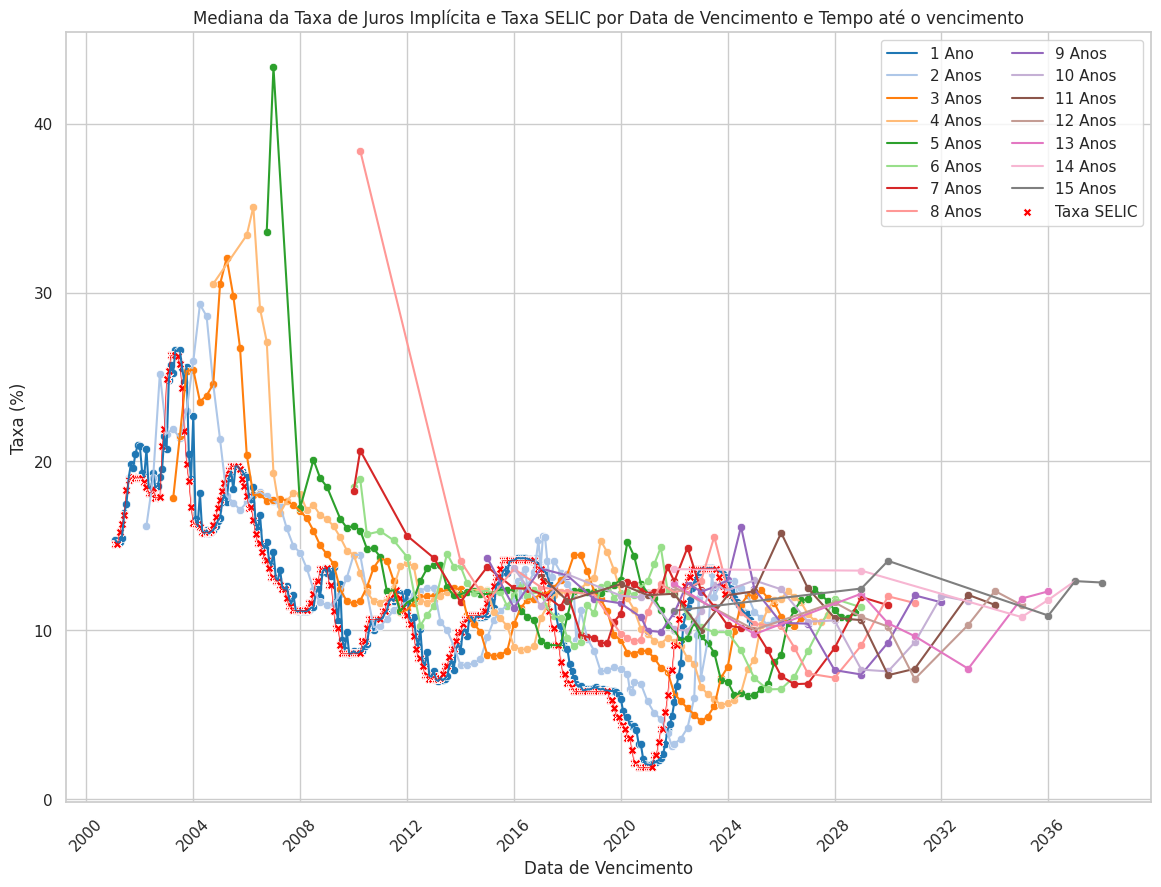

In [28]:
#Agora usando as medians como base para plotar o gráfico de dispersão e linhas
medianas = df.groupby(['VENCTO_EXPLICADO', 'grupos_de_vencimentos'])['Taxa_Juros_Implícita'].median().reset_index()
# Definindo o estilo do gráfico
sns.set(style="whitegrid")
# Criando o gráfico de dispersão
plt.figure(figsize=(14, 10))
# Plotando as linhas e os pontos para cada categoria de grupos_de_vencimentos
palette = sns.color_palette('tab20', n_colors=len(medianas['grupos_de_vencimentos'].unique()))
for i, (t_vcto, group_df) in enumerate(medianas.groupby('grupos_de_vencimentos')):
    sns.lineplot(x='VENCTO_EXPLICADO', y='Taxa_Juros_Implícita', data=group_df, color=palette[i], label=t_vcto)
    sns.scatterplot(x='VENCTO_EXPLICADO', y='Taxa_Juros_Implícita', data=group_df, color=palette[i])
# Plotando a Taxa SELIC como 'x'
sns.scatterplot(x='VENCTO_EXPLICADO', y='Taxa_SELIC', data=df, color='red', label='Taxa SELIC', marker='X')
# Interligando os pontos da Taxa SELIC com uma linha mais fina
sns.lineplot(x='VENCTO_EXPLICADO', y='Taxa_SELIC', data=df, color='red', linewidth=0.4)
# Adicionando títulos e rótulos
plt.title('Mediana da Taxa de Juros Implícita e Taxa SELIC por Data de Vencimento e Tempo até o vencimento')
plt.xlabel('Data de Vencimento')
plt.ylabel('Taxa (%)')
plt.xticks(rotation=45)
# 26. Ajustando a legenda para o canto inferior direito em duas colunas
plt.legend(ncol=2)
plt.show()

O gráfico apresentado concentra-se na mediana das taxas de juros implícitas em contraste com a taxa Selic, em função da data de vencimento e categorizada pela tempo até o vencimento do contrato. Este método de visualização, utilizando a mediana, proporciona uma representação mais robusta que não é tão suscetível a valores extremos, oferecendo uma visão geral mais estável das tendências centrais dos dados.

Analisando as séries temporais criadas pelas medianas, é evidente que contratos com vencimento no prazo de um ano seguem mais de perto a trajetória da taxa Selic, ilustrando uma sincronia entre as expectativas do mercado para o curto prazo e as decisões políticas monetárias atuais, assim como já percebemos na análise de dispersão anterior. Esta tendência se dilui à medida que o prazo de vencimento se estende, refletindo a crescente incerteza ou a diversidade de expectativas para o futuro.

O gráfico também destaca a série que representa a mediana das taxas implícitas para contratos com vencimento em um ano, sublinhando sua relevância e alinhamento com a taxa Selic. A consistência desta série ao longo do tempo enfatiza a confiança do mercado nas políticas monetárias de curto prazo e a sua capacidade de antecipar movimentos da taxa Selic com uma margem de erro relativamente pequena.

Esta análise fornece uma perspectiva valiosa sobre a interação entre as expectativas de mercado, refletidas nas taxas de juros implícitas, e a política monetária do Banco Central, representada pela taxa Selic. A utilização das medianas na visualização dos dados permite identificar padrões mais substanciais e minimizar a influência de valores atípicos, resultando numa interpretação mais clara das tendências gerais e do comportamento do mercado financeiro.

In [29]:
# Calculando a diferença absoluta entre as taxas
df['Diferença_Absoluta'] = abs(df['Taxa_Juros_Implícita'] - df['Taxa_SELIC'])
# Agrupando por 'grupos_de_vencimentos' e calculando a média da diferença absoluta
analise_vcto = df.groupby('grupos_de_vencimentos')['Diferença_Absoluta'].agg(['mean', 'median', 'std'])
# 27. Exibindo o resultado
print(analise_vcto)

                           mean    median       std
grupos_de_vencimentos                              
1 Ano                  1.054909  0.569999  1.387215
2 Anos                 3.476982  2.909995  2.827496
3 Anos                 4.574530  4.309999  3.035398
4 Anos                 5.036014  5.049999  3.259965
5 Anos                 4.738428  4.169998  3.371153
6 Anos                 4.735589  3.450001  3.497671
7 Anos                 4.599969  3.484001  3.320691
8 Anos                 4.060102  3.699999  3.202306
9 Anos                 4.158786  2.799998  3.322649
10 Anos                4.556721  2.880000  3.794961
11 Anos                6.685733  4.390001  3.533022
12 Anos                3.344680  3.410002  0.635824
13 Anos                3.591222  3.600000  0.320924
14 Anos                4.789380  4.474962  1.169790
15 Anos                1.990950  2.018999  0.753788


A tabela gerada a partir da diferença absoluta entre a taxa de juros implícita e a taxa Selic, segmentada por anos até o vencimento, fornece uma análise quantitativa da precisão das expectativas do mercado em relação à taxa oficial. A métrica `mean` (média) oferece uma noção geral do desvio, enquanto a `median` (mediana) tende a dar uma ideia do desvio típico, sendo menos sensível a valores extremos. O `std` (desvio padrão) indica o quão dispersos estão os desvios em torno da média.

Os dados revelam que, para contratos com um ano até o vencimento, a média da diferença absoluta é relativamente baixa, com uma mediana ainda menor, o que sugere que a maioria das taxas de juros implícitas são bastante próximas da taxa Selic. Isso se alinha com a observação de que contratos com vencimento mais próximo tendem a refletir mais precisamente as condições atuais do mercado.

À medida que avançamos para contratos com mais anos até o vencimento, a média e a mediana das diferenças aumentam até o ponto de cinco anos, indicando maior incerteza nas expectativas de longo prazo do mercado. Isso é esperado, uma vez que previsões de longo prazo são naturalmente mais difíceis e sujeitas a uma variedade maior de influências econômicas e políticas. Surpreendentemente, para contratos com mais de 11 anos de até o vencimento, observa-se uma variação significativa na média das diferenças absolutas, sugerindo uma incerteza ainda maior e uma possível dispersão de expectativas sobre a direção futura das taxas de juros.

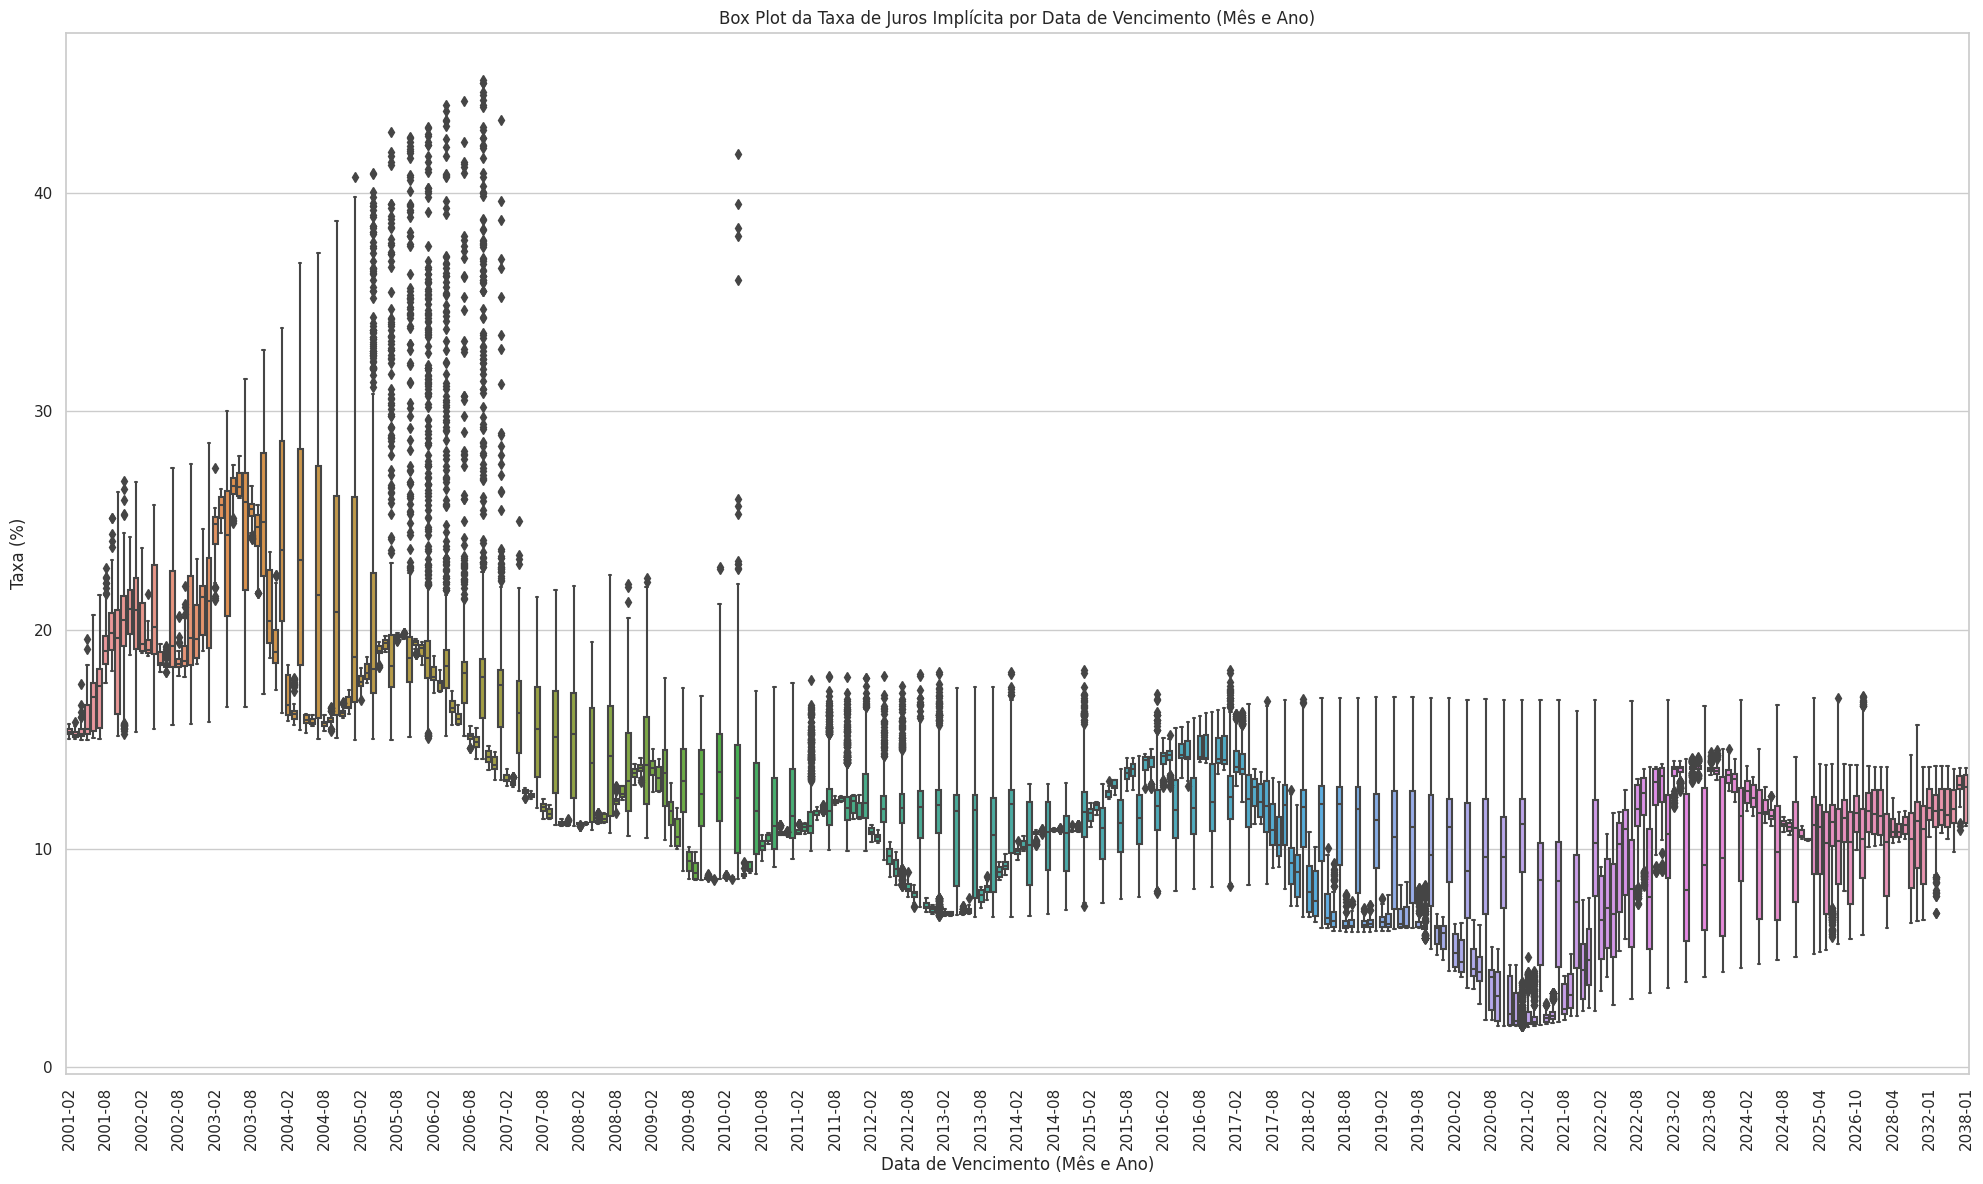

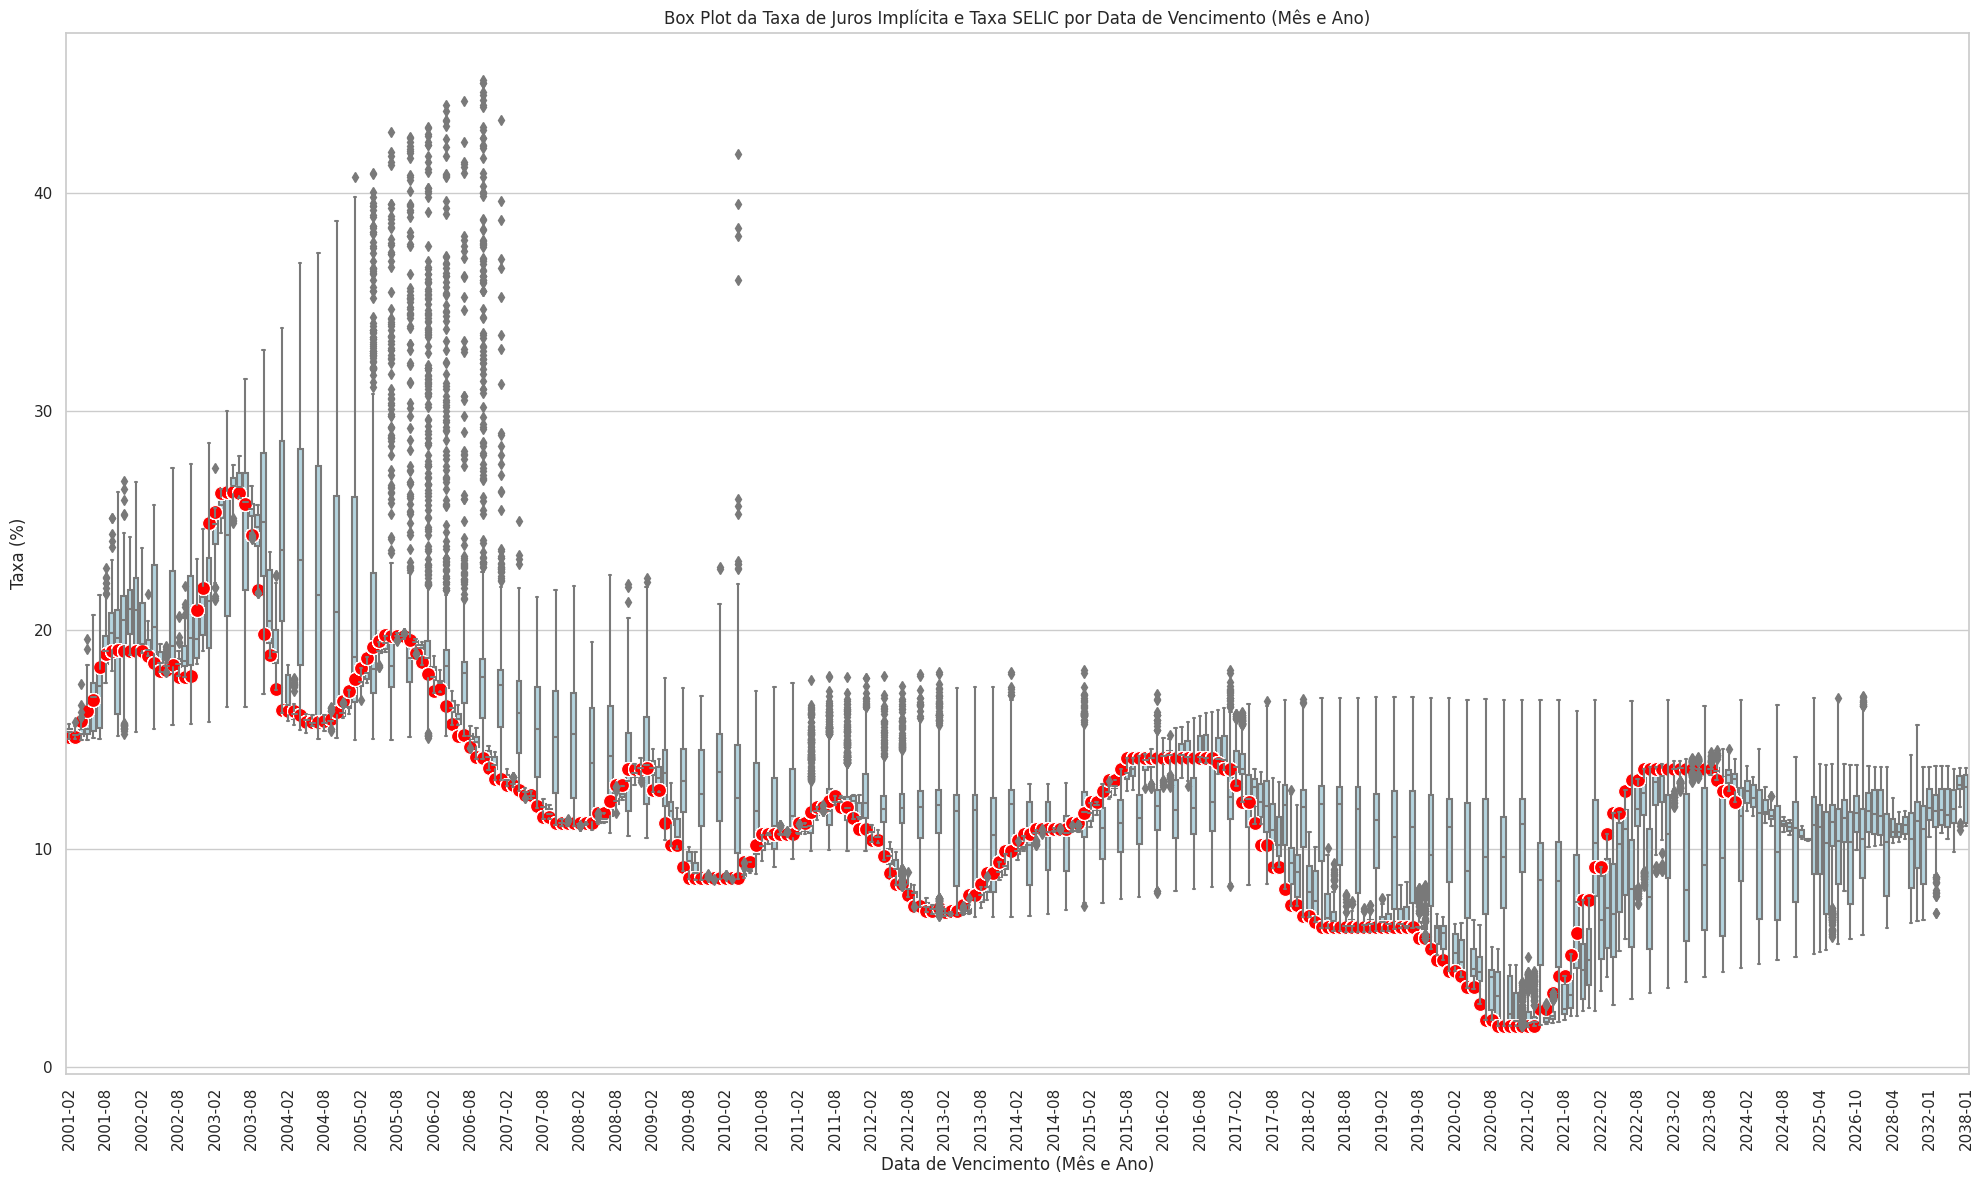

In [30]:
#Candles
# Convertendo 'VENCTO_EXPLICADO' para string no formato 'Mês-Ano' diretamente no gráfico
vencto_formatado = df['VENCTO_EXPLICADO'].dt.to_period('M').dt.strftime('%Y-%m')

# Obtendo todos os rótulos únicos e selecionando um subconjunto para exibir de 6 em 6 meses
rotulos_unicos = vencto_formatado.unique()
rotulos_selecionados = {rotulo: ("" if i % 6 != 0 else rotulo) for i, rotulo in enumerate(rotulos_unicos)}

# 28. Primeiro Gráfico: Box Plot da Taxa de Juros Implícita
plt.figure(figsize=(20, 12))
sns.boxplot(x=vencto_formatado, y='Taxa_Juros_Implícita', data=df)
plt.title('Box Plot da Taxa de Juros Implícita por Data de Vencimento (Mês e Ano)')
plt.xlabel('Data de Vencimento (Mês e Ano)')
plt.ylabel('Taxa (%)')
plt.xticks(rotation=90)
plt.gca().set_xticklabels([rotulos_selecionados.get(label.get_text(), "") for label in plt.gca().get_xticklabels()])
plt.tight_layout()
plt.show()

# 29. Segundo Gráfico: Box Plot da Taxa de Juros Implícita e Taxa SELIC
plt.figure(figsize=(20, 12))
sns.boxplot(x=vencto_formatado, y='Taxa_Juros_Implícita', data=df, color='lightblue')
sns.scatterplot(x=vencto_formatado, y='Taxa_SELIC', data=df, color='red', s=100)
plt.title('Box Plot da Taxa de Juros Implícita e Taxa SELIC por Data de Vencimento (Mês e Ano)')
plt.xlabel('Data de Vencimento (Mês e Ano)')
plt.ylabel('Taxa (%)')
plt.xticks(rotation=90)
plt.gca().set_xticklabels([rotulos_selecionados.get(label.get_text(), "") for label in plt.gca().get_xticklabels()])
plt.tight_layout()
plt.show()


Os gráficos de "candlestick" ou "velas" são uma técnica de representação gráfica usada principalmente para ilustrar movimentos de preço em mercados financeiros ao longo do tempo. Cada "candle" fornece informações visuais sobre a abertura, fechamento, alta e baixa de preços em um determinado período.

No contexto deste trabalho, embora não seja um gráfico de candlestick tradicional utilizado em análises técnicas de ações, nesta abordagem buscamos emular uma ideia semelhante por meio de box plots. Cada "candle" ou caixa no box plot representa a distribuição da taxa de juros implícita para um determinado vencimento, com a linha mediana indicando a taxa de juros mediana implícita, as bordas da caixa representando o primeiro e terceiro quartis e as linhas externas mostrando o alcance dos dados, exceto por pontos discrepantes, que são indicados como pontos individuais.

No primeiro gráfico, plotamos apenas os box plots individualmente para cada vencimento de contrato, porém, já no segundo gráfico, alinhamos a taxa Selic respectiva de cada data de vencimento.

Podemos destacar ainda que, aquele salto surpreendente da expectativa de taxa de juros para os anos de 2006 e 2007, mencionado anteriormente na análise com o gráfico de dispersão, pode ser observado como uma grande núvem de outliers que, na verdade, se agrupam nesta parte do gráfico desde meados de 2005 até o início de 2007.

Visualmente, parece que a taxa selic se mantem dentro do range estipulado pelo intervalo interquartil dos box plots, indicando alinhamento entre as expectativas do mercado e a política monetária oficial. Mas é interessante análisar se, em algum ano, a taxa selic poderia ser equiparada a um outlier caso fosse calculada como taxa de juros implicita.

In [31]:
# Vamos verificar se há algum dado de Taxa Selic fora do intervalor interquartil dos box plots
# Passo 1: Calcular estatísticas para cada período da taxa de juros implícita
estatisticas_implícita = df.groupby(df['VENCTO_EXPLICADO'].dt.to_period('M'))['Taxa_Juros_Implícita'].agg(['median', 'quantile'])
estatisticas_implícita['q1'] = df.groupby(df['VENCTO_EXPLICADO'].dt.to_period('M'))['Taxa_Juros_Implícita'].quantile(0.25)
estatisticas_implícita['q3'] = df.groupby(df['VENCTO_EXPLICADO'].dt.to_period('M'))['Taxa_Juros_Implícita'].quantile(0.75)

# Passo 2: Agrupar a taxa SELIC por período e calcular a média
selic_por_periodo = df.groupby(df['VENCTO_EXPLICADO'].dt.to_period('M'))['Taxa_SELIC'].mean()

# Passo 3: Juntar as estatísticas em uma tabela
tabela_comparativa = pd.concat([estatisticas_implícita, selic_por_periodo], axis=1).rename(columns={'median': 'Mediana', 'q1': 'Q1', 'q3': 'Q3', 'Taxa_SELIC': 'Taxa SELIC Média'})

# Transpondo a tabela para ter períodos como colunas
tabela_comparativa_transposta = tabela_comparativa.T

# 30. Exibindo a tabela
print(tabela_comparativa_transposta)

VENCTO_EXPLICADO    2001-02    2001-03    2001-04    2001-05    2001-06    2001-07    2001-08    2001-09    2001-10    2001-11    2001-12    2002-01    2002-02    2002-03    2002-04    2002-05    2002-06    2002-07    2002-08    2002-09    2002-10    2002-11    2002-12    2003-01    2003-02    2003-03    2003-04    2003-05    2003-06    2003-07    2003-08    2003-09    2003-10    2003-11    2003-12    2004-01    2004-02    2004-03    2004-04    2004-05    2004-06    2004-07    2004-08    2004-09    2004-10    2004-11    2004-12    2005-01    2005-02    2005-03    2005-04    2005-05    2005-06    2005-07    2005-08    2005-09    2005-10    2005-11    2005-12    2006-01    2006-02    2006-03    2006-04    2006-05    2006-06    2006-07    2006-08    2006-09    2006-10    2006-11    2006-12    2007-01    2007-02    2007-03    2007-04    2007-05    2007-06    2007-07    2007-08    2007-09    2007-10    2007-11    2007-12    2008-01    2008-02    2008-03    2008-04    2008-05    2008-06  \
M

In [32]:
# Passo 4: Calcular o Intervalo Interquartílico (IQR)
tabela_comparativa['IQR'] = tabela_comparativa['Q3'] - tabela_comparativa['Q1']

# Passo 5: Identificar os períodos onde a média da taxa Selic está fora do IQR
fora_do_iqr = tabela_comparativa.apply(
    lambda row: row['Taxa SELIC Média'] < row['Q1'] or row['Taxa SELIC Média'] > row['Q3'], axis=1)

# Passo 6: Filtrar os períodos onde a Taxa SELIC está fora do IQR
periodos_fora_do_iqr = tabela_comparativa[fora_do_iqr]

# Passo 7: Exibir os períodos e as taxas correspondentes
print("Períodos onde a Taxa SELIC está fora do IQR:")
print(periodos_fora_do_iqr[['Mediana', 'Q1', 'Q3', 'Taxa SELIC Média']])


Períodos onde a Taxa SELIC está fora do IQR:
                    Mediana         Q1         Q3  Taxa SELIC Média
VENCTO_EXPLICADO                                                   
2001-02           15.350811  15.229254  15.493157             15.12
2001-04           15.257007  15.132808  15.473868             15.83
2001-07           17.460259  15.537907  18.198866             18.32
2001-09           19.849511  19.098015  20.795915             19.05
2001-11           20.443256  19.245919  21.575067             19.05
...                     ...        ...        ...               ...
2023-04            8.110001   5.752499  12.499996             13.65
2023-07            9.232999   6.290001  12.749995             13.65
2023-09           13.549993  13.402002  13.670004             13.15
2023-11           13.367501  12.990748  13.577746             12.65
2023-12           13.180997  12.586258  13.420244             12.15

[196 rows x 4 columns]


A presença da taxa Selic fora do IQR em determinados períodos indicam momentos em que as expectativas do mercado quanto à política monetária divergiram das ações reais do Banco Central. Isso pode ocorrer devido a eventos inesperados na economia que levaram a mudanças rápidas nas taxas de juros. Os períodos com maiores desvios podem também refletir uma maior volatilidade do mercado, onde as incertezas econômicas ou políticas podem ter causado variações significativas nas expectativas de juros futuros.

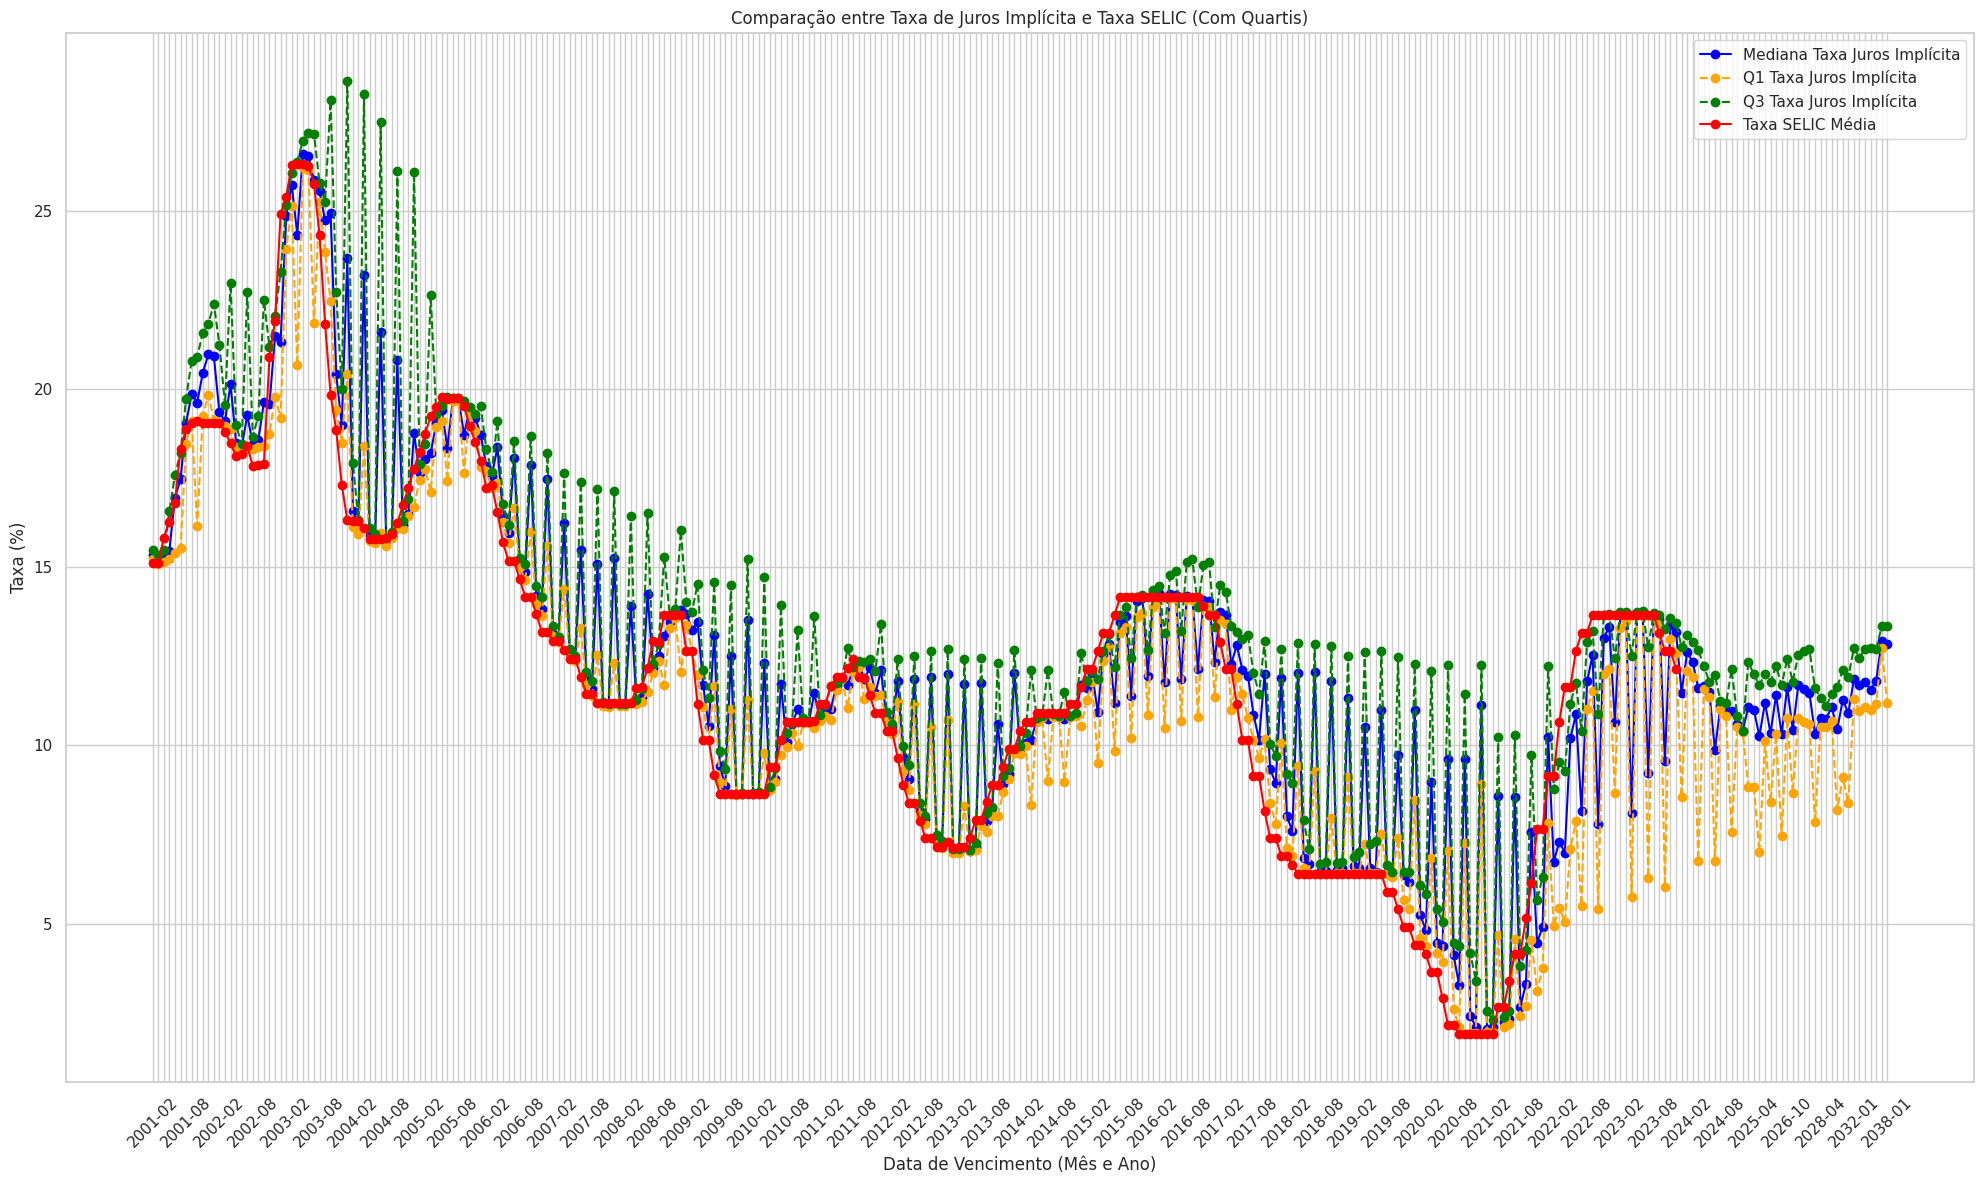

In [33]:
# Separamndo os dados para o gráfico
datas = tabela_comparativa_transposta.columns
datas_formatadas = [str(data) for data in datas]
mediana = tabela_comparativa_transposta.loc['Mediana']
q1 = tabela_comparativa_transposta.loc['Q1']
q3 = tabela_comparativa_transposta.loc['Q3']
selic_media = tabela_comparativa_transposta.loc['Taxa SELIC Média']

# Configurando o estilo e tamanho do gráfico
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

# Plotando a Mediana da Taxa de Juros Implícita
plt.plot(datas_formatadas, mediana, label='Mediana Taxa Juros Implícita', color='blue', marker='o')

# Plotando os quartis como linhas tracejadas
plt.plot(datas_formatadas, q1, label='Q1 Taxa Juros Implícita', color='orange', linestyle='dashed', marker='o')
plt.plot(datas_formatadas, q3, label='Q3 Taxa Juros Implícita', color='green', linestyle='dashed', marker='o')

# Plotando a Taxa SELIC Média
plt.plot(datas_formatadas, selic_media, label='Taxa SELIC Média', color='red', marker='o')

# Adicionando título, rótulos e legenda
plt.title('Comparação entre Taxa de Juros Implícita e Taxa SELIC (Com Quartis)')
plt.xlabel('Data de Vencimento (Mês e Ano)')
plt.ylabel('Taxa (%)')

# Ajustando os rótulos do eixo x
plt.xticks([i for i, label in enumerate(datas_formatadas) if label in rotulos_selecionados], [rotulos_selecionados[label] for label in datas_formatadas], rotation=45)

plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Neste ponto montamos uma visualização gráfica da relação entre as taxas de juros implícitas e a taxa Selic ao longo do tempo, utilizando dessa vez como medida representativa as medianas gerais e os quartis das taxas implícitas, e pontos para a taxa Selic média. O gráfico permite uma comparação direta entre a tendência central das taxas implícitas e a taxa Selic efetiva em cada período, destacando as oscilações e a volatilidade no mercado de juros.

A explicação do gráfico indica que, apesar das flutuações notáveis nas taxas implícitas, há uma tendência de acompanhamento da taxa Selic. Isso sugere que, embora haja períodos de discrepância significativa — possivelmente devido a eventos econômicos ou mudanças na política monetária — as taxas implícitas tendem a se reajustar e seguir a tendência da taxa Selic. As oscilações mencionadas nos períodos específicos refletem momentos de incerteza ou ajustes no mercado que afetaram as expectativas dos investidores. O comportamento geral das taxas implícitas, seguindo o padrão da taxa Selic, sugere que as expectativas de mercado, apesar de voláteis, são influenciadas pelos movimentos da política monetária e pelas condições econômicas que determinam a taxa Selic.

Com isso, podemos concluir que, apesar do tempo para o vencimento do contrato ser um fator de extrema influência na proximidade da taxa de juros implicita calculada com a taxa selic, puramente a mediana das taxas implicitas agrupadas pela data de vencimento já conseguem mostrar uma proximidade relativamente boa com a série histórica da taxa selic, inclusive no comportamento a longo prazo, respeitando as tendências observadas pela série da taxa selic ao longo do tempo.

As notáveis ociliações da mediana da taxa de juros implíita calculada podem ser destacadas nos seguintes períodos: de fevereiro de 2003 até fevereiro de 2005, agosto de 2005 até agosto de 2008, fevereiro de 2009 até agosto de 2010, dezembro de 2012 até fevereiro de 2014, fevereiro de 2015 até fevereiro de 2017, agosto de 2017 até agosto de 2023.







### 5.3.14 - Análise ACF e PACF

A Análise de Função de Autocorrelação (ACF) e a Análise de Função de Autocorrelação Parcial (PACF) são ferramentas estatísticas usadas para identificar padrões de dependência em séries temporais. A ACF mede a correlação entre observações de uma série temporal separadas por diferentes períodos de tempo, enquanto a PACF mede a correlação entre as observações com um intervalo, removendo os efeitos das correlações de ordens inferiores.

Neste contexto, vamos tentar explicar a auto dependência das medianas da taxas de juros implicitas e da taxa selic para, posteriormente, compará-las entre si.

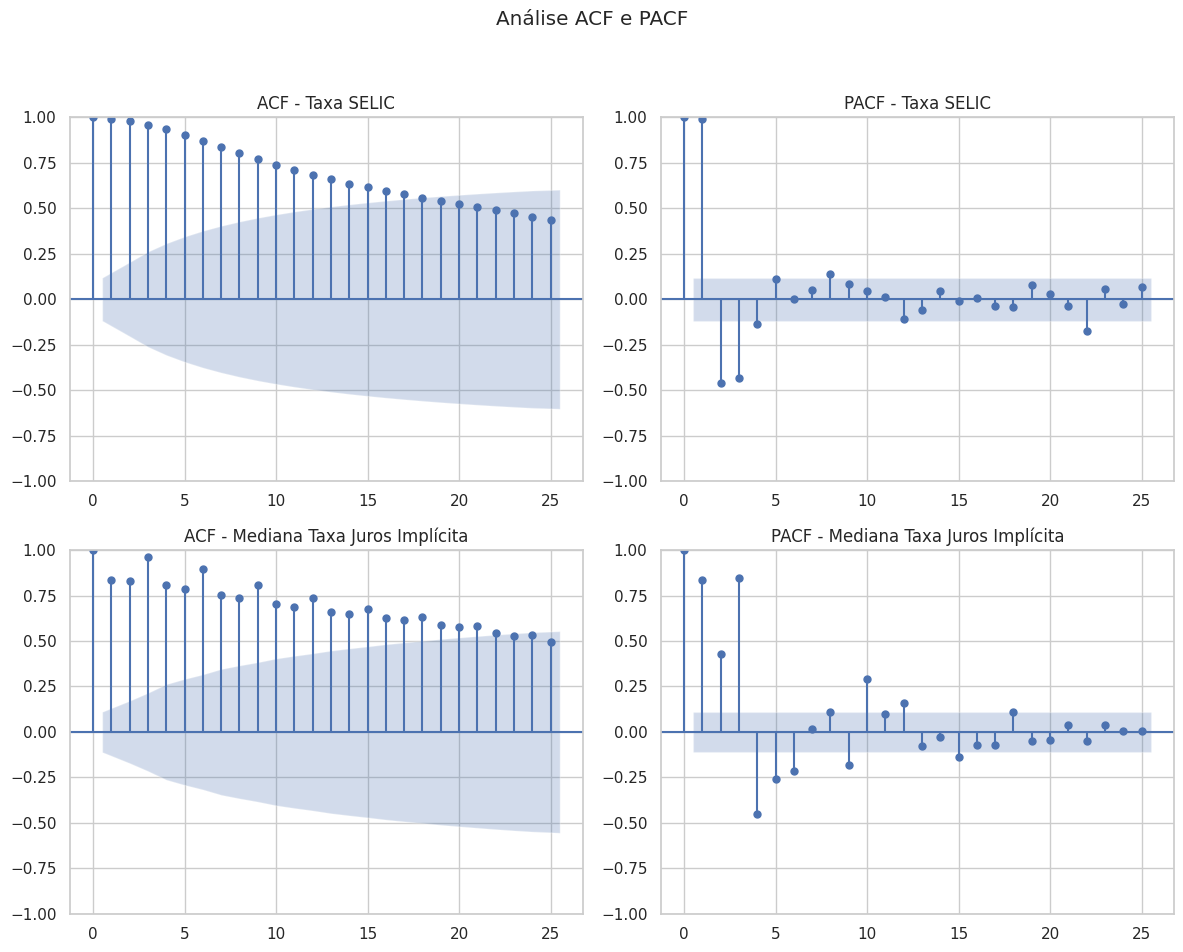

In [34]:
# Extrair as séries temporais
serie_selic = tabela_comparativa_transposta.loc['Taxa SELIC Média']
serie_mediana = tabela_comparativa_transposta.loc['Mediana']

# Tratar os valores ausentes (removendo neste exemplo)
serie_selic = serie_selic.dropna()
serie_mediana = serie_mediana.dropna()

# Preparar a figura para os gráficos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Análise ACF e PACF')

# Realizando e plotando ACF e PACF para Taxa SELIC
plotar_acf_pacf(serie_selic, 'Taxa SELIC', axes[0])

# Realizando e plotando ACF e PACF para Mediana das Taxas de Juros Implícitas
plotar_acf_pacf(serie_mediana, 'Mediana Taxa Juros Implícita', axes[1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [35]:
# Extraindo os valores de ACF e PACF
valores_acf_taxa_implicita = acf(serie_mediana, nlags=20)
valores_pacf_taxa_implicita = pacf(serie_mediana, nlags=20)
valores_acf_selic = acf(serie_selic, nlags=20)
valores_pacf_selic = pacf(serie_selic, nlags=20)

# Imprimindo os valores
print("Valores ACF para Mediana das Taxas implicitas:")
print(valores_acf_taxa_implicita)
print('\n')
print("\nValores PACF para Mediana das Taxas implicitas:")
print(valores_pacf_taxa_implicita)
print('\n')
print("Valores ACF para Taxa Selic:")
print(valores_acf_selic)
print('\n')
print("\nValores PACF para Taxa Selic:")
print(valores_pacf_selic)

Valores ACF para Mediana das Taxas implicitas:
[1.         0.83481614 0.82751438 0.9621104  0.80550179 0.78732123
 0.89414043 0.75387334 0.73443366 0.80880335 0.70303641 0.68528791
 0.73904036 0.66111062 0.6486711  0.67836585 0.62634512 0.61376257
 0.63112772 0.58950827 0.57533342]



Valores PACF para Mediana das Taxas implicitas:
[ 1.          0.83749183  0.44018812  0.88184529 -0.43412798 -0.35342381
 -0.39101997 -0.03595264  0.24770989 -0.10858869  0.43744914  0.28665294
  0.44924232 -0.0950169  -0.44493185 -1.20785518  3.97828273  0.97813177
 10.17918035 -1.05338159 -0.57025223]


Valores ACF para Taxa Selic:
[1.         0.99322734 0.98024427 0.95994274 0.93410941 0.90471896
 0.87205906 0.8379362  0.80383566 0.7705938  0.73932445 0.71043379
 0.68335739 0.65840038 0.6356317  0.61447932 0.59509226 0.57649644
 0.5582476  0.54087802 0.52377393]



Valores PACF para Taxa Selic:
[  1.           0.99685226  -1.00052853 187.41392958   1.01283607
  -1.37642749   0.56731045   1.33311904  -0

Os padrões observados na ACF para as medianas das taxas implícitas mostram uma forte autocorrelação inicial que diminui gradualmente, sugerindo uma inércia na série onde valores passados têm um impacto duradouro no futuro próximo. Esta é uma característica comum em séries financeiras, onde a tendência ou o nível geral muda lentamente ao longo do tempo. Por outro lado, a ACF da taxa Selic permanece alta por mais defasagens, indicando uma persistência mais longa e estabilidade na série temporal da taxa Selic.

Quanto à PACF, a série das medianas das taxas implícitas apresenta alguns picos e quedas significativos em intervalos específicos, o que pode indicar influências pontuais ou reações do mercado a eventos específicos. A série da taxa Selic, contudo, mostra um padrão mais errático na PACF, com valores extremos que podem refletir ajustes abruptos na política monetária ou respostas a eventos macroeconômicos.

Ao comparar as duas séries, percebe-se que a taxa Selic tem uma autocorrelação mais estável, o que é esperado de uma taxa de referência estabelecida pelo banco central, que tende a mudar de forma mais previsível e suave. Já as taxas implícitas, sendo derivadas de contratos de mercado e sujeitas a expectativas e especulações, mostram uma autocorrelação mais volátil, refletindo o dinamismo e a incerteza do mercado.

### 5.3.15 - Análise de correlação e dispersão entre a Taxa Selic e as Taxas de Juros Implícitas

Nesta etapa, estamos realizando uma análise de correlação com foco especial na Taxa SELIC e na Taxa de Juros Implícita.

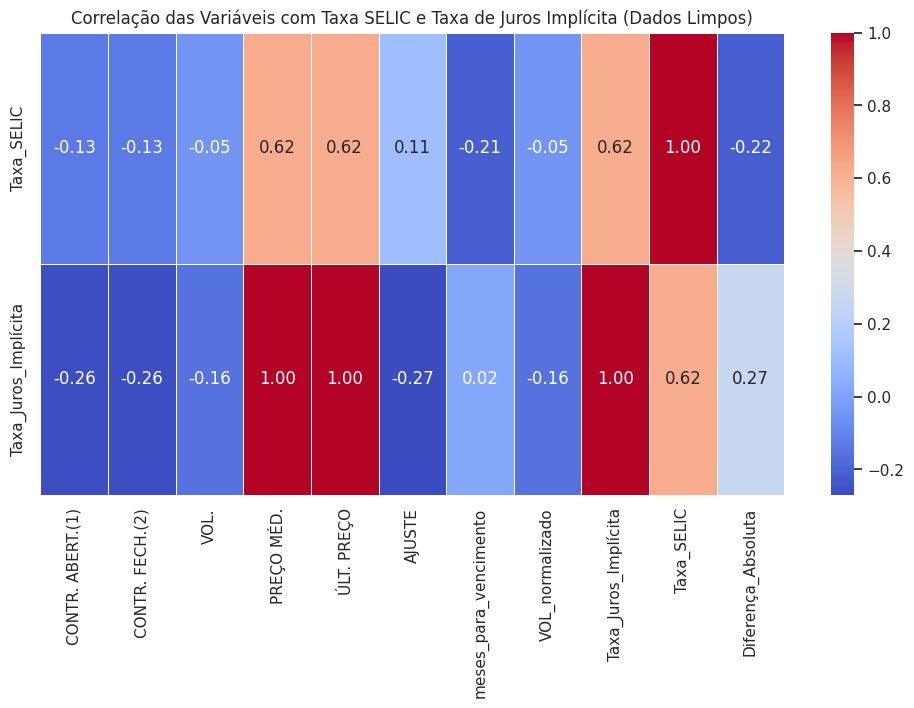

In [36]:
#Correlações das novas variáveis
# Removendo linhas com NaN em Taxa_SELIC ou Taxa_Juros_Implícita
df_limpo = df.dropna(subset=['Taxa_SELIC', 'Taxa_Juros_Implícita'])

# Calculando a matriz de correlação para as colunas limpas
corr_matrix_limpa = df_limpo.corr()

# Extraindo correlações específicas para Taxa_SELIC e Taxa_Juros_Implícita
correlacoes_selecionadas = corr_matrix_limpa.loc[['Taxa_SELIC', 'Taxa_Juros_Implícita'], :]

# Plotando o heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlacoes_selecionadas, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlação das Variáveis com Taxa SELIC e Taxa de Juros Implícita (Dados Limpos)')
plt.show()

Primeiro, limpamos o dataframe removendo linhas com valores ausentes nessas duas variáveis de taxa. Depois, calculamos a matriz de correlação entre todas as variáveis numéricas disponíveis e extraímos as linhas relevantes para Taxa SELIC e Taxa de Juros Implícita. Finalmente, visualizamos essas correlações específicas por meio de um heatmap, assim com realizado na seção 5.3.4, porém focado na relação entre a Taxa de Juros Implícita e a Taxa Selic.

Alinhado ao que já haviamos observado análisando as séries temporais anteriores, com o heatmap de correlação podemos ver que Taxa de Juros Implícita está fortemente correlacionada linearmente com a Taxa SELIC, o que indica que a expectativa do mercado refletida nas taxas implícitas acompanha de perto a taxa de referência oficial. Isso mostra que as expectativas de mercado para as taxas de juros futuras estão alinhadas, lienarmente, com a trajetória da política monetária.

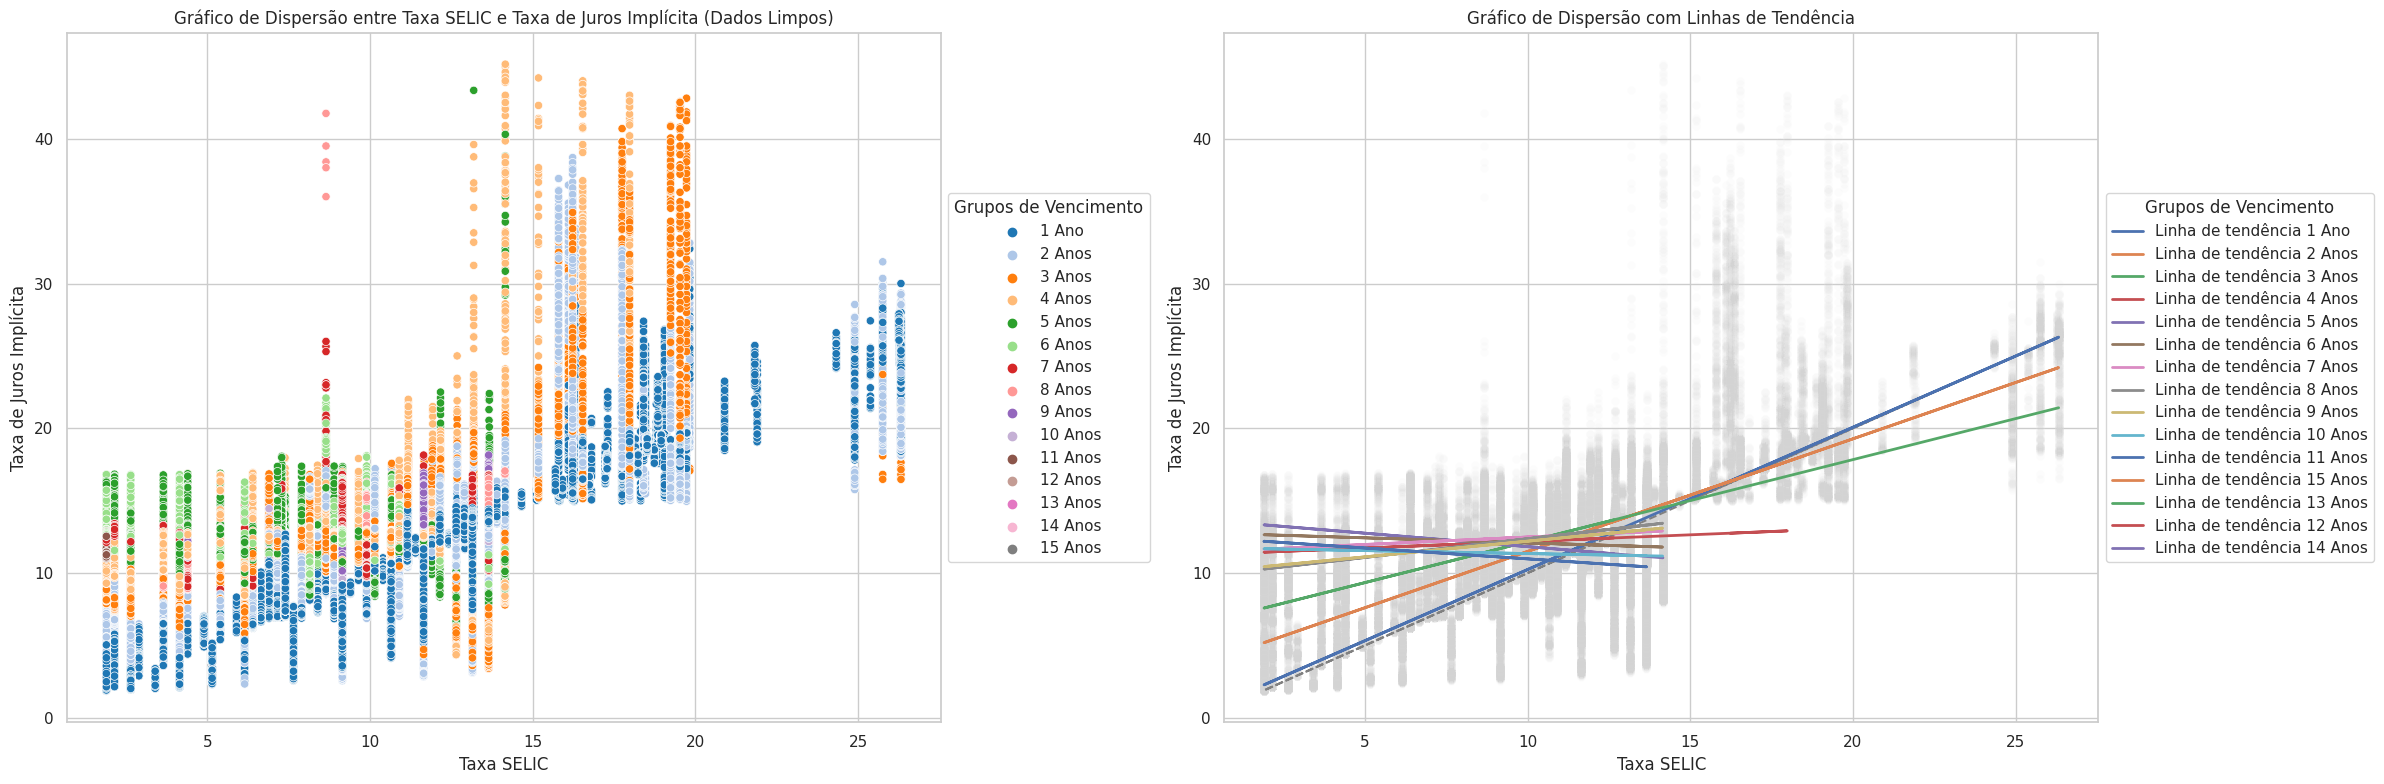

In [37]:
# Configurando a figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Gráfico Original sem Legenda
sns.scatterplot(ax=axes[0], x='Taxa_SELIC', y='Taxa_Juros_Implícita', data=df_limpo, hue='grupos_de_vencimentos', palette='tab20')
axes[0].set_title('Gráfico de Dispersão entre Taxa SELIC e Taxa de Juros Implícita (Dados Limpos)')
axes[0].set_xlabel('Taxa SELIC')
axes[0].set_ylabel('Taxa de Juros Implícita')
#axes[0].get_legend().remove() # Removendo a legenda

# Gráfico com Linhas de Tendência
sns.scatterplot(ax=axes[1], x='Taxa_SELIC', y='Taxa_Juros_Implícita', data=df_limpo, color='lightgray', alpha=0.05)
axes[1].plot(df_limpo['Taxa_SELIC'], df_limpo['Taxa_SELIC'], color='gray', linestyle='--')

for t_vcto in df_limpo['grupos_de_vencimentos'].unique():
    subset = df_limpo[df_limpo['grupos_de_vencimentos'] == t_vcto]
    z = np.polyfit(subset['Taxa_SELIC'], subset['Taxa_Juros_Implícita'], 1)
    p = np.poly1d(z)
    axes[1].plot(subset['Taxa_SELIC'], p(subset['Taxa_SELIC']), linewidth=2, label=f'Linha de tendência {t_vcto}')

axes[1].set_title('Gráfico de Dispersão com Linhas de Tendência')
axes[1].set_xlabel('Taxa SELIC')
axes[1].set_ylabel('Taxa de Juros Implícita')

# Mantendo a legenda
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Grupos de Vencimento')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Grupos de Vencimento')

plt.tight_layout()
plt.show()

Neste trecho do trabalho estamos exibindo a relação de dispersão entre o dados de taxas de juros implícitas em função da taxa Selic. Assim podemos ver como que, para um determinado dado de taxa Selic, os dados de taxas de juros implícitas se distribuem agrupados por tempo para o vencimento.

Aliado a isso, temos as linhas de tendência dessas distribuições segmentadas por tempo para o vecimento. Foi plotada uma linha traçejada na cor cinza com coeficiente angular igual a 1, que representa exatamente os pontos exatos de taxa selic para cada observação vertical. Assim, podemos mais facilmente ver o quão cada distribuição por vencimento está de fato próxima da taxa selic referente à uma determinada data de vencimento.

Para complementar essa análise visual, vamos introduzir estatísticas de regressão para cada uma das linhas de tendência. Isso nos permitirá quantificar as relações observadas e fornecer uma compreensão mais detalhada de como as expectativas de taxas de juros implícitas se relacionam com a taxa Selic ao longo do tempo. As estatísticas de regressão nos ajudarão a entender a força, a direção e a significância dessas relações, oferecendo uma visão mais concreta e mensurável das tendências do mercado.

In [38]:
# Criando um DataFrame vazio para armazenar os resultados
resultados_regressao = pd.DataFrame(columns=['Tempo até o Vencimento', 'Coeficiente', 'Intercepto', 'R-quadrado', 'p-value'])

for t_vcto in df_limpo['grupos_de_vencimentos'].unique():
    subset = df_limpo[df_limpo['grupos_de_vencimentos'] == t_vcto]

    # Verificando se há variação suficiente nos dados
    if len(subset['Taxa_SELIC'].unique()) > 1:
        X = subset['Taxa_SELIC']
        y = subset['Taxa_Juros_Implícita']
        X = sm.add_constant(X) # adicionando uma constante

        # Realizando a regressão
        model = sm.OLS(y, X).fit()

        # Armazenando os resultados
        resultados_regressao = resultados_regressao.append({
            'Tempo até o Vencimento': t_vcto,
            'Coeficiente': model.params[1],
            'Intercepto': model.params[0],
            'R-quadrado': model.rsquared,
            'p-value': model.pvalues[1] # p-value para o coeficiente
        }, ignore_index=True)

# Exibindo as tabelas estatísticas
print(resultados_regressao)

   Tempo até o Vencimento  Coeficiente  Intercepto  R-quadrado        p-value
0                   1 Ano     0.983115    0.411507    0.892869   0.000000e+00
1                  2 Anos     0.778001    3.713543    0.429596   0.000000e+00
2                  3 Anos     0.566503    6.507174    0.180627   0.000000e+00
3                  4 Anos     0.091406   11.270696    0.006183   4.076172e-20
4                  5 Anos    -0.185735   13.682443    0.091839  1.263941e-196
5                  6 Anos    -0.069565   12.780358    0.021686   6.324797e-24
6                  7 Anos     0.102588   11.460064    0.056191   8.936901e-35
7                  8 Anos     0.258267    9.786346    0.287578  1.853179e-151
8                  9 Anos     0.216884   10.033672    0.397709  4.733734e-178
9                 10 Anos    -0.041299   11.760061    0.030735   3.911499e-09
10                11 Anos    -0.149870   12.479711    0.506095   1.512641e-73


Analisando as estatísticas de regressão das diferentes categorias de tempo até o vencimento em relação à linha de referência (coeficiente angular = 1, que representaria um alinhamento perfeito com a taxa Selic), observamos o seguinte:

- Categorias Mais Próximas da Linha de Referência (Taxa Selic):

 A categoria referente a 1 Ano de para o vencimento do contrato se destaca com um coeficiente angular de 0.983, quase alinhado perfeitamente com a linha de referência. Isso indica que as taxas de juros implícitas para contratos com vencimento em um ano seguem de perto as variações da taxa Selic. As categorias "2 Anos" e "3 Anos" ainda apresentam um alinhamento de certa forma significativo quando comparados aos restos dos resultados, porém decaem demonstrando que, conforme nos distânciamos do vencimento, aumentas as incertezas.

- Desvios Significativos:

  As categorias "4 Anos" e "5 Anos" apresentam desvios significativos, com coeficientes angulares de 0.091 e -0.186, respectivamente. Esses valores distantes de 1 indicam uma relação muito fraca ou até inversa com a taxa Selic. Isso sugere que as expectativas do mercado para esses períodos podem ser influenciadas por outros fatores além da taxa Selic. As regressões de 6, 10 e 11 anos também apresentam um coeficiente negativo.

- Relação Moderada:
  
  As categorias como "8 Anos" e "9 Anos" possuem coeficientes angulares de 0.258 e 0.217, respectivamente. Embora estejam mais alinhados com a taxa Selic do que as categorias de médio prazo, ainda estão distantes do ideal representado pela linha de referência.

- Variação do Intercepto:

  O intercepto varia entre as categorias, indicando diferentes níveis base das taxas de juros implícitas em relação à Selic. Por exemplo, as categorias de longo prazo tendem a ter interceptos mais altos, sugerindo que suas taxas implícitas partem de um ponto mais elevado em comparação com a Selic.

- R-quadrado:

  O valor de R-quadrado varia consideravelmente, sendo maior para "1 Ano" e "11 Anos". Isso significa que a taxa de juros implícita para contratos com um ano de vencimento é mais previsível e tem uma relação mais forte com a taxa Selic do que as outras categorias, uma vez que mesmo que tenha um R-quadrado relevante, a taxa regressão de "11 Anos" apresenta um coeficênte angular negativo, não justificando uma relação forte com a taxa Selic em sí. Adicionalmente, categorias como 4, 5, 6 e 10 têm valores de R-quadrado mais baixos, indicando uma relação menos significativa com a Selic.

- p-value:

  Todos os p-values são extremamente baixos, reforçando a significância estatística das relações encontradas.

Em resumo, a análise mostra que as taxas de juros implícitas para contratos com vencimento mais próximo têm uma correlação mais forte e direta com a taxa Selic. No entanto, para períodos de vencimento mais longos, essa relação se torna mais fraca ou até divergente, indicando a influência de outros fatores além da Selic na formação das expectativas do mercado.

## 5.4 - Holdout

A divisão em conjunto de treino e teste é um passo crucial no processo de modelagem preditiva. O conjunto de treino é usado para ajustar o modelo, enquanto o conjunto de teste serve para avaliar sua performance e generalização para dados não vistos anteriormente. Este método, conhecido como holdout, é fundamental para testar a robustez do modelo preditivo.

In [39]:
# Removendo as colunas 'VOL_normalizado' e 'Grupo_Volume'
df_limpo = df_limpo.drop(['VOL_normalizado', 'Grupo_Volume'], axis=1)

# Selecionando as variáveis para o treinamento
X = df_limpo.drop('Taxa_SELIC', axis=1) # Todas as variáveis, exceto 'Taxa_SELIC'
y = df_limpo['Taxa_SELIC'] # Variável alvo, a 'Taxa_SELIC'

# Dividindo o dataset em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Antes de proceder com a divisão dos dados, removemos as colunas **VOL_normalizado** e **Grupo_Volume**. Essas colunas foram criadas a partir de uma etapa de normalização e categorização dos dados e podem conter informações que refletem o conjunto de dados como um todo, resultando em vazamento de dados (data leaking). A remoção dessas colunas é importante para garantir a integridade do processo de aprendizado do modelo.

A seguir, definimos as variáveis independentes X (todas as variáveis do dataset exceto '**Taxa_SELIC**') e a variável dependente y (a '**Taxa_SELIC**', que é o alvo da nossa previsão).

Utilizamos a função `train_test_split` para dividir o dataset em conjuntos de treino e teste. A função é configurada para alocar 80% dos dados para treino (train) e 20% para teste (test), um split comum em modelagem preditiva.
O parâmetro `random_state=42` garante que a divisão seja reproduzível, ou seja, a mesma divisão será feita sempre que o código for executado, o que é importante para a consistência nos testes e na validação do modelo.

In [40]:
#Verificando os conjuntos
print("Conjunto de Treino:\n")
print("Variáveis independentes:")
print(X_train)
print("\nVariável dependente:")
print(y_train)

print("\nConjunto de Teste:\n")
print("Variáveis independentes:")
print(X_test)
print("\nVariável dependente:")
print(y_test)

Conjunto de Treino:

Variáveis independentes:
       VENCTO  CONTR. ABERT.(1)  CONTR. FECH.(2)         VOL.  PREÇO MÉD.  ÚLT. PREÇO    AJUSTE       Data VENCTO_EXPLICADO  meses_para_vencimento grupos_de_vencimentos  Taxa_Juros_Implícita  Diferença_Absoluta
19586     J08             27146            27146      7716490   14.710000   14.710000  77164.90 2006-05-05       2008-04-01                     23                2 Anos             14.710001            3.530001
99766     K21            103190           103685    148406199    2.098000    2.100000  98614.30 2020-08-25       2021-05-01                      9                 1 Ano              2.090002            0.559998
21608     V08             20080            20595     89545721   13.828000   13.840000  76839.47 2006-09-14       2008-10-01                     25                3 Anos             13.844996            0.184996
91965     N20             64990            67350    172410450   12.428000   12.400000  62304.20 2016-06-07    

# 6 - Conclusão

Este trabalho realizou uma análise aprofundada dos dados históricos de contratos futuros de DI em relação à taxa SELIC, com o objetivo de entender como o mercado futuro de DI reflete e influencia as expectativas do mercado em relação à política monetária do Brasil.

## 6.1 - Principais Achados e Implicações

- Relação com o tempo para o vencimennto dos Contratos:

Foi observado que o tempo para o vencimennto dos contratos está intrinsecamente ligada à precisão das taxas de juros implícitas. Contratos com vencimentos mais próximos tendem a ter uma relação mais forte e direta com a taxa SELIC, refletindo as expectativas imediatas do mercado no curto prazo.

- Variações Históricas e Padrões de Correlação:

A análise histórica mostrou variações significativas nas taxas de juros implícitas ao longo do tempo. Em certos períodos, notadamente por volta de 2006-2007, observou-se um descolamento entre as taxas implícitas e a SELIC, indicativo das dinâmicas do mercado e das expectativas futuras, que posteriormente se traduziram como outliers quando fizemos a análise histórica dos box plots.

- Análise de Componentes Principais (PCA):

Na análise de componentes principais (PCA), identificamos duas dimensões principais que possívelmente capturam aspectos distintos dos dados de contratos futuros de DI:

- - Primeiro Componente Principal - "Tamanho" ou "Escala" do Mercado:

    O primeiro componente principal reflete principalmente o 'tamanho' ou 'escala' do mercado. Ele é fortemente influenciado por atributos como volume de negociação e número de contratos abertos e fechados. Este componente sugere que contratos com volumes maiores e mais transações têm um papel significativo na formação das expectativas do mercado sobre taxas futuras.

- - Segundo Componente Principal - Dinâmica de Preços e Taxas de Juros:

    O segundo componente apresenta uma dinâmica diferente, relacionada aos preços e taxas de juros. Com todos os pesos positivos e significativos para características de preço e taxa de juros, este componente pode estar capturando variações nos preços dos contratos e nas expectativas de taxas de juros, que são fundamentais na determinação das taxas de juros implícitas.

- Dispersão das Taxas de Juros Implícitas em Relação à SELIC:

Os gráficos de dispersão e as análises de regressão linear mostraram que, embora exista uma correlação geral entre as taxas implícitas e a SELIC, esta relação varia substancialmente em função do tempo de vencimento do contrato.

- Análises de regressão:

As análises de regressão revelaram que enquanto contratos com vencimento de um ano têm forte correlação com a SELIC, contratos de médio e longo prazo são influenciados por outros fatores, sugerindo uma complexidade maior na formação das expectativas de mercado.

- Análise ACF e PACF:

As análises ACF e PACF indicaram padrões distintos de auto dependência para a mediana das taxas implícitas e a taxa SELIC, o que reforça a ideia de que a formação das taxas de juros implícitas envolve uma série de fatores além das mudanças na SELIC.


## 6.2 - Implicações para Modelagem Preditiva

Com base nos achados, a fase de modelagem preditiva deverá considerar a variabilidade das taxas implícitas em função do prazo de vencimento e a complexidade das relações com a taxa SELIC. Modelos que incorporam a liquidez dos contratos e consideram diferentes horizontes temporais podem ser mais eficazes para prever movimentos futuros da SELIC. Além disso, as variações históricas e os descolamentos observados indicam que modelos robustos e adaptativos serão necessários para capturar a dinâmica do mercado.








## 6.3 - Considerações Finais

Este estudo proporcionou insights valiosos sobre a relação entre os contratos futuros de DI e a taxa SELIC. Os resultados destacam a importância de considerar uma variedade de fatores, incluindo o tempo para o vencimento e liquidez dos contratos e as expectativas de mercado, na análise desses instrumentos financeiros. As descobertas aqui apresentadas podem ser um ponto de partida para pesquisas futuras e desenvolvimento de modelos preditivos mais sofisticados no campo da economia e finanças.